In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [29]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *

%aimport data_analysis_utils_dataframes

from data_analysis_utils_dataframes import *
from data_analysis_utils_performance import *
# import supervised_classification as supc    

In [11]:
inverse_means_map = np.load('/home/spbproc/euso-spb-patt-reco-v1/resources/inverse_flat_average_directions_4m_flipud.npy')

# Selecting the simu data

In [35]:
model_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20181129'
data_snippets_dir = 'ver4_machine_learning_trg_classification'

os.makedirs(data_snippets_dir, exist_ok=True)

In [13]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

## Columns

In [14]:
rfecv_selector_on_extra_trees__column_names = []

columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'r') as columns_list_file:
    rfecv_selector_on_extra_trees__column_names = columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20181129/rfecv_selector_on_extra_trees__column_names.txt


In [15]:
rfecv_selector_on_extra_trees__column_names__special = []

special_columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'r') as special_columns_list_file:
    rfecv_selector_on_extra_trees__column_names__special = special_columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20181129/rfecv_selector_on_extra_trees__column_names__special.txt


In [16]:
# This should be empty for now
rfecv_selector_on_extra_trees__column_names__special

[]

In [17]:
simu_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=\
        [('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu')] + \
        rfecv_selector_on_extra_trees__column_names
)
print_columns_dict(simu_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_trg_x_y_clusters
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_trg_gtu_x_clusters
	- max_size_clu_height
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_trg_gtu_y_clusters
	- max_size_clu_height
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_orig_x_y
	- count_nonzero

spb_processing_v4_simu_flatmap.event_proc2_x_y_clusters
	- max_peak_clu_width

spb_processing_v4_simu_flatmap.event_proc3_x_y_clusters
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_proc2_gtu_y_clusters
	- max_size_clu_height

spb_processing_v4_simu_flatmap.event_bg_x_y
	- count_nonzero

spb_p

## Constructing the query

In [18]:
source_data_type_num_classification = 3001
source_data_type_num_filter = 1001

In [19]:
current_columns_for_analysis_dict = simu_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_format = \
'''
AND {does_exist} EXISTS (
    SELECT e2.event_id FROM spb_processing_v4_simu_flatmap.event AS e2 
    WHERE 
        e2.source_data_type_num={source_data_type_num:d} 
        AND spb_processing_v4_simu_flatmap.event.source_file_acquisition=e2.source_file_acquisition 
        AND (
            (spb_processing_v4_simu_flatmap.event.gtu_in_packet <= e2.gtu_in_packet AND e2.gtu_in_packet - spb_processing_v4_simu_flatmap.event.gtu_in_packet < spb_processing_v4_simu_flatmap.event.num_gtu - 4) 
            OR 
            (e2.gtu_in_packet < spb_processing_v4_simu_flatmap.event.gtu_in_packet AND spb_processing_v4_simu_flatmap.event.gtu_in_packet - e2.gtu_in_packet < e2.num_gtu - 4)
        )
)
'''

simu_where_clauses_str = simu_where_clauses_format.format(does_exist='', source_data_type_num=source_data_type_num_filter)

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)


simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num_classification,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

print(simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.clu_areas_max AS trg_x_y_clusters_clu_areas_max, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_size_clu_width AS trg_x_y_clusters_max_size_clu_width, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_size_clu_height AS trg_x_y_clusters_max_size_clu_height, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_peak_clu_width AS trg_x_y_clusters_max_peak_clu_width, spb_processing_v4_simu_flatmap.eve

In [20]:
count_filtered_out_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num_classification,
    select_additional='COUNT(*)', 
    join_additional='',
    where_additional=simu_where_clauses_format.format(does_exist='NOT', source_data_type_num=source_data_type_num_filter),
    order_by=None, 
    offset=0, limit=350000,
    base_select='')

print(count_filtered_out_query)


    SELECT 
        
        COUNT(*)
     FROM spb_processing_v4_simu_flatmap.event
     
    WHERE
        source_data_type_num = 3001
        
AND NOT EXISTS (
    SELECT e2.event_id FROM spb_processing_v4_simu_flatmap.event AS e2 
    WHERE 
        e2.source_data_type_num=1001 
        AND spb_processing_v4_simu_flatmap.event.source_file_acquisition=e2.source_file_acquisition 
        AND (
            (spb_processing_v4_simu_flatmap.event.gtu_in_packet <= e2.gtu_in_packet AND e2.gtu_in_packet - spb_processing_v4_simu_flatmap.event.gtu_in_packet < spb_processing_v4_simu_flatmap.event.num_gtu - 4) 
            OR 
            (e2.gtu_in_packet < spb_processing_v4_simu_flatmap.event.gtu_in_packet AND spb_processing_v4_simu_flatmap.event.gtu_in_packet - e2.gtu_in_packet < e2.num_gtu - 4)
        )
)

    
    OFFSET 0 LIMIT 350000
    


## Selecting the data

In [21]:
simu_bgf1_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [22]:
simu_bgf1_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_clu_areas_max,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,138,...,0,35283,1,1.000000e+13,0.696797,4.65066,27000000.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,78,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
4,11499,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0


## Adding additional information

In [23]:
add_bin_column(simu_bgf1_df, 'num_frames_signals_ge_bg', 5);

In [24]:
simu_bgf1_df['is_visible'] = \
    (simu_bgf1_df['num_frames_signals_ge_bg'] >= 2) & (simu_bgf1_df['num_frames_signals_ge_bg'] <= 999) & \
    (32 <= simu_bgf1_df['gtu_in_packet']) & (simu_bgf1_df['gtu_in_packet'] <= 52)
# TODO 32 <= gtu_in_packet <= 52 range in not ideal

In [25]:
print("len(simu_df)                       ", len(simu_bgf1_df))
print("len(simu_df[simu_df['is_visible']])", len(simu_bgf1_df[simu_bgf1_df['is_visible']]))

len(simu_df)                        18919
len(simu_df[simu_df['is_visible']]) 13535


In [26]:
def shorted_simu2npy_pathname(x, remove_until_str='SPBDATA_processed/spb_simu/', simu2npy_pathname_col='simu2npy_pathname'):
    s = x[simu2npy_pathname_col]
    try:
        short_path = s[s.index(remove_until_str)+len(remove_until_str):]
    except ValueError:
        short_path = s
        
    return short_path


def simu2npy_signals_pathname(x, replaced_suffix='__info.txt', replacement_suffix='_mc_1__signals.npy', simu2npy_pathname_col='simu2npy_pathname'):
    s = x[simu2npy_pathname_col]
    if not s.endswith(replaced_suffix):
        raise RuntimeError('Unexpected contents of simu2npy_pathname')
    s_new = s[:-len(replaced_suffix)] + replacement_suffix
    return s_new


simu_bgf1_df['simu2npy_signals_pathname'] = simu_bgf1_df.apply(simu2npy_signals_pathname, axis=1)
simu_bgf1_df['simu2npy_signals_pathname_short'] = simu_bgf1_df.apply(lambda x: shorted_simu2npy_pathname(x, simu2npy_pathname_col='simu2npy_signals_pathname'), axis=1)

In [179]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

simu_bgf1_df, unclassified_simu_bgf1_df, track_simu_bgf1_df, noisy_simu_bgf1_df, \
simu_bgf1_signal_track_events_df, simu_bgf1_signal_noisy_events_df = \
    data_analysis_utils_dataframes.add_classification_columns(
        simu_bgf1_df, 
        simu_signal_visible_tracks_table_path, 
        simu_signal_noisy_events_table_path,
        save_simu_events_mask=True,
        recreate_simu_events_mask=True,
        simu_events_file_pathname_dir=data_snippets_dir,
        simu_signal_has_track_check=lambda arr: arr >= 2
    )

0/18919
100/18919
200/18919
300/18919
400/18919
500/18919
600/18919
700/18919
800/18919
900/18919
1000/18919
1100/18919
1200/18919
1300/18919
1400/18919
1500/18919
1600/18919
1700/18919
1800/18919
1900/18919
2000/18919
2100/18919
2200/18919
2300/18919
2400/18919
2500/18919
2600/18919
2700/18919
2800/18919
2900/18919
3000/18919
3100/18919
3200/18919
3300/18919
3400/18919
3500/18919
3600/18919
3700/18919
3800/18919
3900/18919
4000/18919
4100/18919
4200/18919
4300/18919
4400/18919
4500/18919
4600/18919
4700/18919
4800/18919
4900/18919
5000/18919
5100/18919
5200/18919
5300/18919
5400/18919
5500/18919
5600/18919
5700/18919
5800/18919
5900/18919
6000/18919
6100/18919
6200/18919
6300/18919
6400/18919
6500/18919
6600/18919
6700/18919
6800/18919
6900/18919
7000/18919
7100/18919
7200/18919
7300/18919
7400/18919
7500/18919
7600/18919
7700/18919
7800/18919
7900/18919
8000/18919
8100/18919
8200/18919
8300/18919
8400/18919
8500/18919
8600/18919
8700/18919
8800/18919
8900/18919
9000/18919
9100/18919


In [180]:
!ls ver4_machine_learning_trg_classification

066686a70c3e07ddccefdfa429ebf8e6_002329daefa03739c9ecd20611880cd4_89129d42f50979cc097c3e488506528a_simu_noisy_events_mask.pkl
066686a70c3e07ddccefdfa429ebf8e6_002329daefa03739c9ecd20611880cd4_89129d42f50979cc097c3e488506528a_simu_track_events_mask.pkl


## Checking dataset of simu tracks

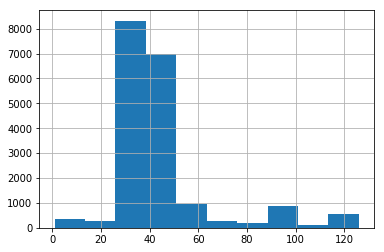

In [181]:
simu_bgf1_df['gtu_in_packet'].hist()
plt.show()

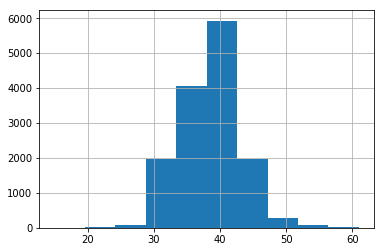

In [182]:
track_simu_bgf1_df['gtu_in_packet'].hist()
plt.show()

<big>Caution</big>
- There should not be too high gtu_in_packet

### Checking few non-track events

In [183]:
# 48941 should not be there !!!
48941 in track_simu_bgf1_df['event_id'].values

False

In [184]:
# 2112010 should not be there. PROBABLY - TOTO INVESTIGATE
2112010 in track_simu_bgf1_df['event_id'].values

False

In [185]:
for i,v in track_simu_bgf1_df[ track_simu_bgf1_df['event_id'] == 2112010 ].iterrows():
    for k,v in v.iteritems():
        print('{:<80} {}'.format(k,v))
    print('='*50)

In [186]:
2548363 in track_simu_bgf1_df['event_id'].values

False

In [187]:
event_2548363_df = track_simu_bgf1_df[ track_simu_bgf1_df['event_id'] == 2548363 ]

for i,r in event_2548363_df.iterrows():
    for k,v in r.iteritems():
        print('{:<80} {}'.format(k,v))
    print('='*50)

In [188]:
2073223 in track_simu_bgf1_df['event_id'].values

False

In [178]:
def _t_add_classification_columns(
        simu_df, simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path, sep='\t', ret_simu_signal=True,
        class_column='cond_selection_simple', track_class='track', noise_class='noise', unclassified_class='unclassified',
        signals_pathname_func=simu2npy_signals_pathname, shorted_pathname_func=shorted_simu2npy_pathname,
        simu_event_start_offset=-4, simu_signal_event_start_offset=-4,
        simu_event_inject_gtu=30, simu_signal_event_inject_gtu=30,
        simu_simu2npy_pathname_short_column='simu2npy_signals_pathname_short',
        simu_signal_simu2npy_pathname_short_column='source_file_acquisition',
        simu_gtu_in_packet_column='gtu_in_packet',
        simu_signal_gtu_in_packet_column='gtu_in_packet',
        simu_num_gtu_column='num_gtu',
        simu_signal_num_gtu_column='num_gtu',
        simu_signal_num_frames_column='num_frames',
        simu_signal_simu2npy_pathname_full_column='source_file_acquisition_full',
        save_simu_events_mask=True,
        recreate_simu_events_mask=False,
        simu_events_file_pathname_dir=None,
        simu_df_hashstr=None,
        simu_signal_visible_tracks_events_table_hashstr=None,
        simu_signal_visible_noisy_events_table_hashstr=None,
        print_status=True,
        simu_signal_has_track_check=lambda arr: arr >= 2
        ):

    simu_signal_track_events_df = pd.read_csv(simu_signal_visible_tracks_table_path, sep=sep)
    simu_signal_noisy_events_df = pd.read_csv(simu_signal_noisy_events_table_path, sep=sep)

    simu_track_events_mask_pathname = None
    simu_noisy_events_mask_pathname = None

    extend_simu_signal_by_signals_pathname(simu_df, signals_pathname_func=signals_pathname_func, shorted_pathname_func=shorted_pathname_func)

    simu_track_events_mask = simu_df[simu_simu2npy_pathname_short_column].isin(simu_signal_track_events_df[simu_signal_simu2npy_pathname_short_column])
    simu_noisy_events_mask = simu_df[simu_simu2npy_pathname_short_column].isin(simu_signal_noisy_events_df[simu_signal_simu2npy_pathname_short_column])

    for i, r in simu_df.iterrows():

        if print_status:
            if i % 100 == 0:
                print('{}/{}'.format(i, len(simu_df)))

        if r['event_id'] != 2073223:
            continue

        simu_first_gtu = r[simu_gtu_in_packet_column] + simu_event_start_offset - simu_event_inject_gtu
        simu_last_gtu = simu_first_gtu + r[simu_num_gtu_column] - 1
        r_pathname = r[simu_simu2npy_pathname_short_column]

        for dest_mask, simu_signal_df in [
            (simu_track_events_mask, simu_signal_track_events_df),
            (simu_noisy_events_mask, simu_signal_noisy_events_df)]:

            if not dest_mask[i]:
                continue

                
                
            simu_signal_subset_df = simu_signal_df[simu_signal_df[simu_signal_simu2npy_pathname_short_column] == r_pathname]

            if len(simu_signal_subset_df) <= 0:
                continue

            # print('len(simu_signal_subset_df)', len(simu_signal_subset_df))

            simu_signal_first_gtu_ser = \
                simu_signal_subset_df[simu_signal_gtu_in_packet_column] + simu_signal_event_start_offset - simu_signal_event_inject_gtu
            simu_signal_last_gtu_ser = \
                simu_signal_first_gtu_ser - 1 + \
                np.min([
                    simu_signal_subset_df[simu_signal_num_frames_column].values,
                    simu_signal_subset_df[simu_signal_num_gtu_column].values], axis=0)

            has_simu_signal_events_ser = (simu_signal_last_gtu_ser >= simu_first_gtu) & (simu_signal_first_gtu_ser <= simu_last_gtu)

            print('simu_first_gtu                          ', simu_first_gtu)
            print('simu_last_gtu                           ', simu_last_gtu)
            print('simu_signal_first_gtu                   ', simu_signal_first_gtu_ser.tolist())
            print('simu_signal_last_gtu                    ', simu_signal_last_gtu_ser.tolist())
            print('(simu_signal_last_gtu >= simu_first_gtu)', (simu_signal_last_gtu_ser >= simu_first_gtu).tolist())
            print('(simu_signal_first_gtu <= simu_last_gtu)', (simu_signal_first_gtu_ser <= simu_last_gtu).tolist())

            for ii in range(len(simu_signal_subset_df)):
                if has_simu_signal_events_ser.iloc[ii]:
                    simu_signals_arr = np.load(simu_signal_subset_df.iloc[ii][simu_signal_simu2npy_pathname_full_column])
                    simu_signals_arr_section = \
                        simu_signals_arr[
                            max(simu_first_gtu, simu_signal_first_gtu_ser.iloc[ii], 0):
                            min(simu_signal_last_gtu_ser.iloc[ii], simu_last_gtu, len(simu_signals_arr)) + 1]
                    
                    print('simu_signals_arr[{}:{}]       '.format(
                            max(simu_first_gtu, simu_signal_first_gtu_ser.iloc[ii], 0),
                            min(simu_signal_last_gtu_ser.iloc[ii], simu_last_gtu, len(simu_signals_arr)) + 1))
                    print('np.max(simu_signals_arr_section)  ', np.max(simu_signals_arr_section))
                    print('np.max(simu_signals_arr_section)  ', np.max(simu_signals_arr_section,axis=(1,2)))
                    print('np.any(simu_signals_arr_section)  ', np.any(simu_signals_arr_section, axis=(1,2)))
                    
                    has_simu_signal_events_ser.iloc[ii] = \
                        np.any(simu_signals_arr_section) if not callable(simu_signal_has_track_check) \
                            else np.any(simu_signal_has_track_check(simu_signals_arr_section))

            dest_mask[i] = np.any(has_simu_signal_events_ser)
            
            print('dest_mask[{}]                           {}'.format(i, dest_mask[i]))

            
            
            
#     simu_df[class_column] = unclassified_class
#     simu_df.loc[simu_track_events_mask, class_column] = track_class
#     simu_df.loc[simu_noisy_events_mask, class_column] = noise_class

#     unclassified_simu_df = simu_df.query('{} == "{}"'.format(class_column, unclassified_class))
#     track_simu_df = simu_df.query('{} == "{}"'.format(class_column, track_class))
#     noisy_simu_df = simu_df.query('{} == "{}"'.format(class_column, noise_class))

#     if ret_simu_signal:
#         return simu_df, unclassified_simu_df, track_simu_df, noisy_simu_df, simu_signal_track_events_df, simu_signal_noisy_events_df

#     return simu_df, unclassified_simu_df, track_simu_df, noisy_simu_df


_t_add_classification_columns(simu_bgf1_df, simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path)

0/18919
100/18919
200/18919
300/18919
400/18919
500/18919
600/18919
700/18919
800/18919
900/18919
1000/18919
1100/18919
1200/18919
1300/18919
1400/18919
1500/18919
1600/18919
1700/18919
1800/18919
1900/18919
2000/18919
2100/18919
2200/18919
2300/18919
2400/18919
2500/18919
2600/18919
2700/18919
2800/18919
2900/18919
3000/18919
3100/18919
3200/18919
3300/18919
3400/18919
3500/18919
3600/18919
3700/18919
3800/18919
3900/18919
4000/18919
4100/18919
4200/18919
4300/18919
4400/18919
4500/18919
4600/18919
4700/18919
4800/18919
4900/18919
5000/18919
5100/18919
5200/18919
5300/18919
5400/18919
5500/18919
5600/18919
5700/18919
5800/18919
5900/18919
6000/18919
6100/18919
6200/18919
6300/18919
6400/18919
6500/18919
6600/18919
6700/18919
6800/18919
simu_first_gtu                           -8
simu_last_gtu                            6
simu_signal_first_gtu                    [-4]
simu_signal_last_gtu                     [15]
(simu_signal_last_gtu >= simu_first_gtu) [True]
(simu_signal_first_gtu <= 

## Subsets

In [189]:
simu_bgf1_visible_tracks_mask = simu_bgf1_df['is_visible'] & (simu_bgf1_df['cond_selection_simple'] == 'track')

In [190]:
simu_bgf1_tracks_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'track']
simu_bgf1_unclassified_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'unclassified']
simu_bgf1_noise_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'noise']
simu_bgf1_visible_df = simu_bgf1_df[simu_bgf1_df['is_visible']]
simu_bgf1_visible_tracks_df = simu_bgf1_df[simu_bgf1_visible_tracks_mask]

In [191]:
cns = rfecv_selector_on_extra_trees__column_names

simu_bgf1_nonan_df = \
    simu_bgf1_df[
        simu_bgf1_df.isin(
            simu_bgf1_df[cns].dropna()).any(axis=1) ]

simu_bgf1_tracks_nonan_df = \
    simu_bgf1_tracks_df[
        simu_bgf1_tracks_df.isin(
            simu_bgf1_tracks_df[cns].dropna()).any(axis=1) ]

simu_bgf1_unclassified_nonan_df = \
    simu_bgf1_unclassified_df[
        simu_bgf1_unclassified_df.isin(
            simu_bgf1_unclassified_df[cns].dropna()).any(axis=1) ]

simu_bgf1_noise_nonan_df = \
    simu_bgf1_noise_df[
        simu_bgf1_noise_df.isin(
            simu_bgf1_noise_df[cns].dropna()).any(axis=1) ]

simu_bgf1_visible_tracks_nonan_df = \
    simu_bgf1_visible_tracks_df[
        simu_bgf1_visible_tracks_df.isin(
            simu_bgf1_visible_tracks_df[cns].dropna()).any(axis=1) ]


In [192]:
len(simu_bgf1_visible_tracks_df[rfecv_selector_on_extra_trees__column_names].dropna())

13360

In [193]:
print("len(simu_bgf1_df)               ", len(simu_bgf1_df))
print("len(simu_bgf1_tracks_df)        ", len(simu_bgf1_tracks_df))
print("len(simu_bgf1_unclassified_df)  ", len(simu_bgf1_unclassified_df))
print("len(simu_bgf1_noise_df)         ", len(simu_bgf1_noise_df))
print("len(simu_bgf1_visible_tracks_df)", len(simu_bgf1_visible_tracks_df))
print("len(simu_bgf1_visible_tracks_df) / len(simu_bgf1_df)", len(simu_bgf1_visible_tracks_df)/len(simu_bgf1_df))

len(simu_bgf1_df)                18919
len(simu_bgf1_tracks_df)         14449
len(simu_bgf1_unclassified_df)   4465
len(simu_bgf1_noise_df)          5
len(simu_bgf1_visible_tracks_df) 13377
len(simu_bgf1_visible_tracks_df) / len(simu_bgf1_df) 0.707066969712987


In [194]:
print("len(simu_bgf1_nonan_df)               ", len(simu_bgf1_nonan_df))
print("len(simu_bgf1_tracks_nonan_df)        ", len(simu_bgf1_tracks_nonan_df))
print("len(simu_bgf1_unclassified_nonan_df)  ", len(simu_bgf1_unclassified_nonan_df))
print("len(simu_bgf1_noise_nonan_df)         ", len(simu_bgf1_noise_nonan_df))
print("len(simu_bgf1_visible_tracks_nonan_df)", len(simu_bgf1_visible_tracks_nonan_df))
print("len(simu_bgf1_visible_tracks_nonan_df) / len(simu_bgf1_nonan_df)", len(simu_bgf1_visible_tracks_nonan_df)/len(simu_bgf1_nonan_df))

len(simu_bgf1_nonan_df)                18871
len(simu_bgf1_tracks_nonan_df)         14420
len(simu_bgf1_unclassified_nonan_df)   4446
len(simu_bgf1_noise_nonan_df)          5
len(simu_bgf1_visible_tracks_nonan_df) 13360
len(simu_bgf1_visible_tracks_nonan_df) / len(simu_bgf1_nonan_df) 0.7079646017699115


In [195]:
count_filtered_out_cur = event_v3_storage_provider_simu.connection.cursor()
count_filtered_out_cur.execute(count_filtered_out_query)
count_filtered_out_num = count_filtered_out_cur.fetchone()

In [196]:
print('Number of visible events not triggered:',count_filtered_out_num)

Number of visible events not triggered: (809846,)


In [197]:
simu_bgf1_null_rows_df = simu_bgf1_df[ simu_bgf1_df[rfecv_selector_on_extra_trees__column_names].isnull().any(axis=1) ]

In [198]:
print('Number L1(bgf=1) triggered simu evens with null rows (dropped):', len(simu_bgf1_null_rows_df))
print('Number L1(bgf=1) triggered simu evens without null rows (included):', len(simu_bgf1_nonan_df))

Number L1(bgf=1) triggered simu evens with null rows (dropped): 48
Number L1(bgf=1) triggered simu evens without null rows (included): 18871


In [199]:
pd.set_option('display.max_columns', 200)
simu_bgf1_null_rows_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_clu_areas_max,trg_x_y_clusters_max_size_clu_width,trg_x_y_clusters_max_size_clu_height,trg_x_y_clusters_max_peak_clu_width,trg_x_y_clusters_max_peak_clu_height,trg_gtu_x_clusters_max_size_clu_height,trg_gtu_x_clusters_max_peak_clu_height,trg_gtu_y_clusters_max_size_clu_height,trg_gtu_y_clusters_max_peak_clu_height,orig_x_y_count_nonzero,proc2_x_y_clusters_max_peak_clu_width,proc3_x_y_clusters_max_size_clu_height,proc3_x_y_clusters_max_peak_clu_width,proc3_x_y_clusters_max_peak_clu_height,proc2_gtu_y_clusters_max_size_clu_height,bg_x_y_count_nonzero,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_max_peak_clu_size,bg_count_nonzero,bg_size,trg_x_y_hough_peak_thr1_line_clusters_sizes_max,trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max,trg_x_y_hough_peak_thr1_line_clusters_clu_areas_max,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,trg_x_y_hough_peak_thr2_line_clusters_clu_widths_max,trg_x_y_hough_peak_thr2_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_clu_widths_max,trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_height,trg_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max,trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_count,proc2_x_y_hough_peak_thr1_line_clusters_count,proc2_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc2_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,proc2_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc2_x_y_hough_peak_thr2_line_clusters_count,proc2_x_y_hough_peak_thr3_line_clusters_count,proc3_x_y_hough_peak_thr1_line_clusters_count,proc3_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc3_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc3_x_y_hough_peak_thr2_line_clusters_count,proc3_x_y_hough_peak_thr3_line_clusters_count,proc1_gtu_x_hough_peak_thr2_major_line_rho,proc1_gtu_x_hough_peak_thr3_major_line_rho,proc3_gtu_x_hough_peak_thr1_line_clusters_count,proc3_gtu_x_hough_peak_thr2_line_clusters_count,proc2_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max,proc2_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_

In [200]:
pd.reset_option('display.max_columns')

# Applying models

## StandardScaler

In [201]:
standard_scaler_on_train_rfecv_columns_pathname = \
     os.path.join(model_data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')
standard_scaler_on_train_rfecv_columns = joblib.load(standard_scaler_on_train_rfecv_columns_pathname)

In [202]:
simu_bgf1_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [203]:
simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_visible_tracks_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [204]:
simu_bgf1_tracks_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_tracks_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [205]:
simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_unclassified_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

## Extra trees classifier

In [206]:
extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname = \
    os.path.join(model_data_snippets_dir, 'extra_trees_cls_on_train_kbest400_128_est.pkl')
extra_trees_cls_on_train_kbest400_128_est = joblib.load(extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname)

In [207]:
simu_bgf1_nonan__rfecv_columns__y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_bgf1_nonan__rfecv_columns_scaled_X)
simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled__y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X)
simu_bgf1_tracks_nonan__rfecv_columns__y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)
simu_bgf1_unclassified_nonan__rfecv_columns__y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X)

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


Evaluation should be done on a different dataset, because this also contains training data

### Sensitivity on L1 (bgf=1) triggered events

- P - all triggered 
- TP - recognized

#### By particle energy

In [208]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


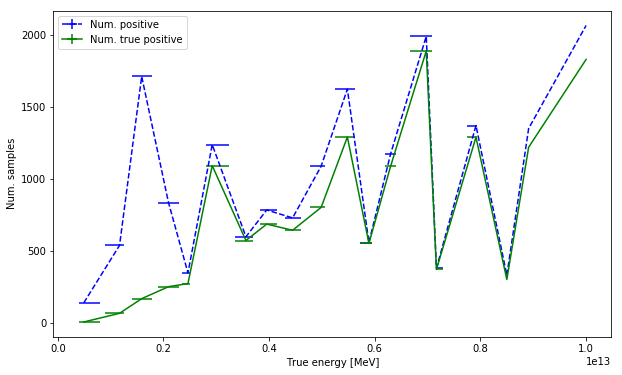

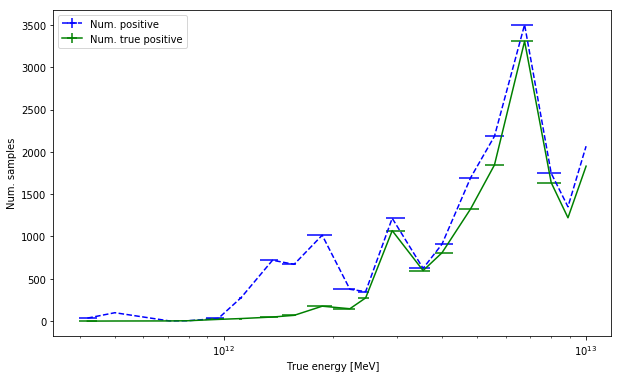

In [209]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

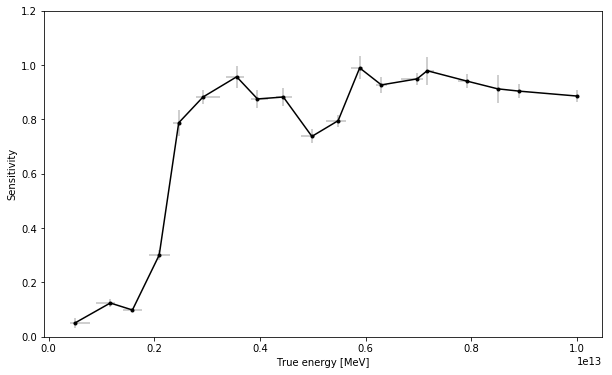

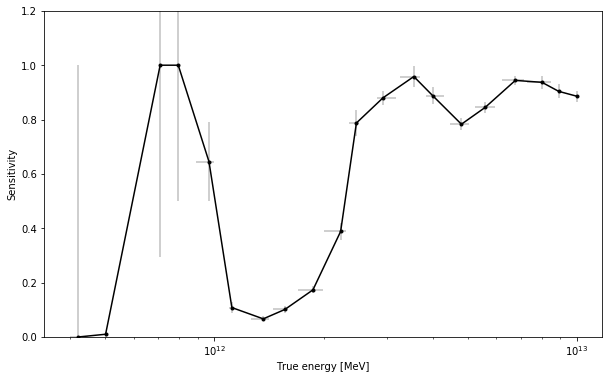

In [210]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

#### By zenith angle (theta)

In [211]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_theta = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truetheta')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


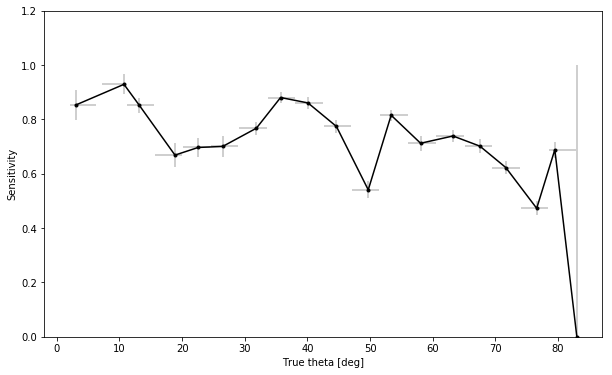

In [212]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_theta, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True theta [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

#### By azimuth angle (phi)

In [213]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_phi = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truephi')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


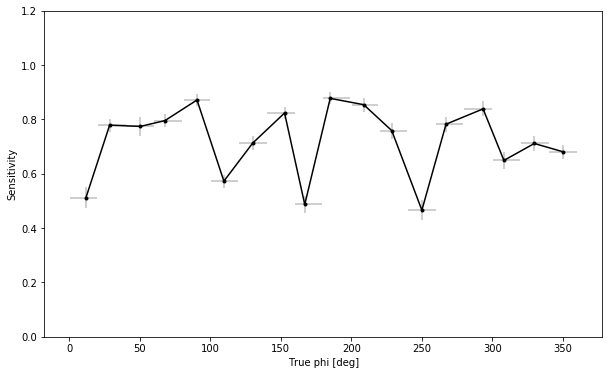

In [214]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_phi, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True phi [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

### Sensitivity on L1 (bgf=1) triggered *visible track* events

#### By particle energy

In [215]:
extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_visible_tracks_nonan_df['event_id'].values, 
        simu_bgf1_visible_tracks_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


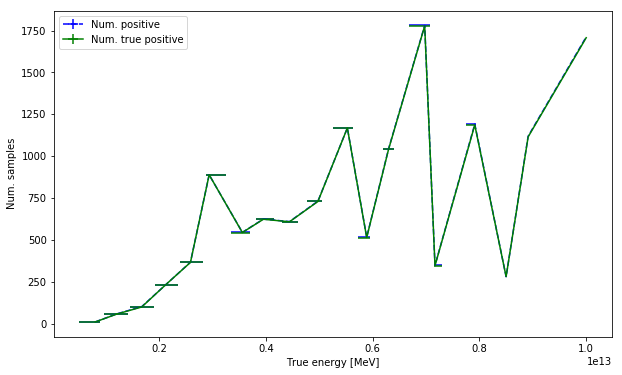

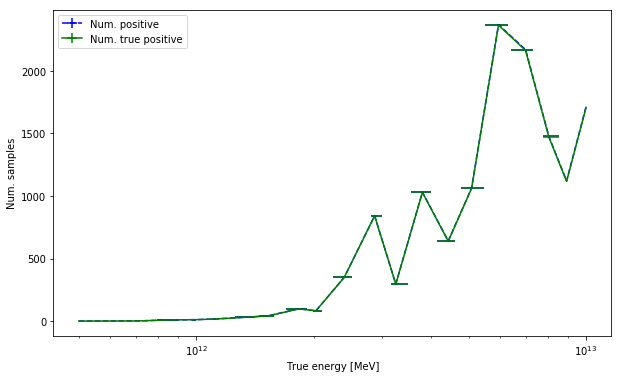

In [216]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

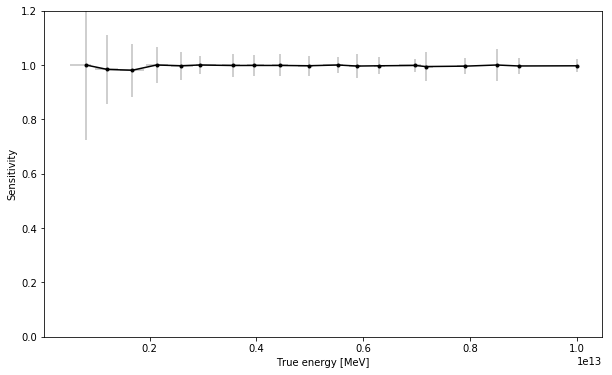

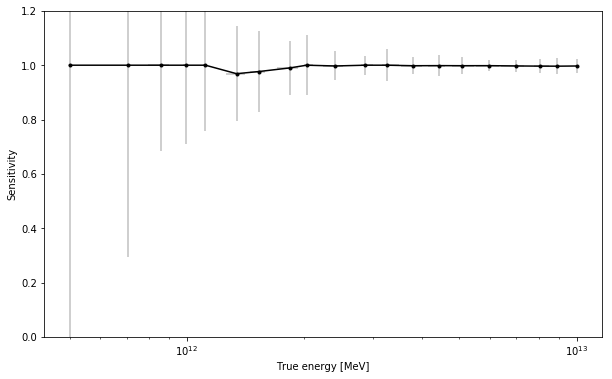

In [217]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

Most of the triggered and visible track events (training and testing data) seem to be selected.

### Sensitivity on L1 (bgf=1) triggered *track* events

#### By particle energy

In [218]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_tracks_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


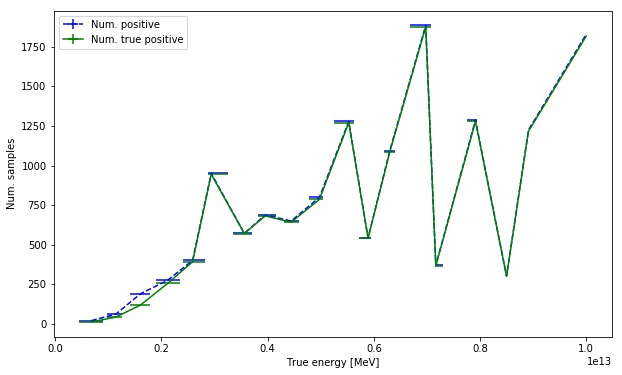

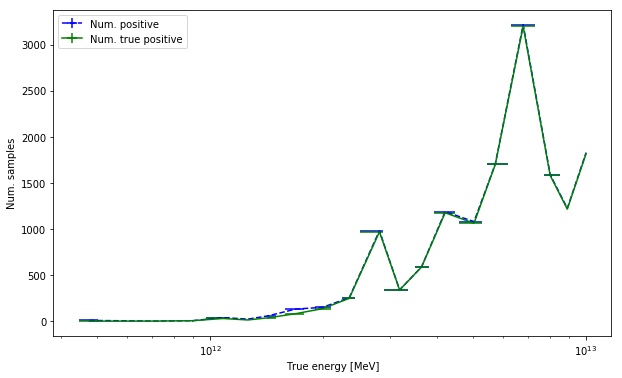

In [219]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

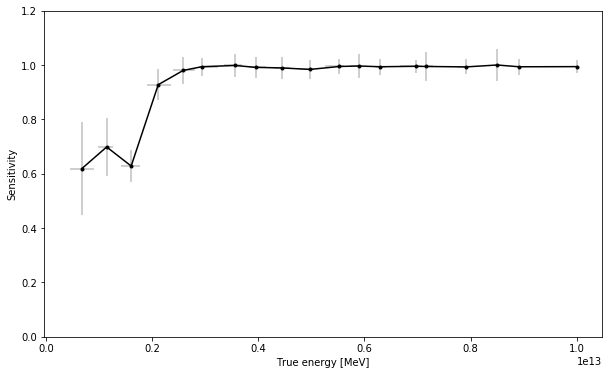

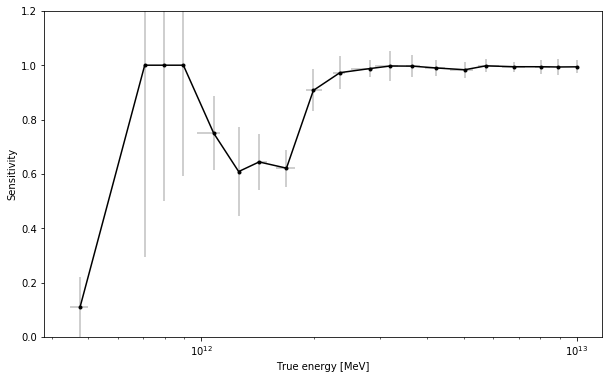

In [220]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

Low energy track events are not recognized. These events seem not to be a part of visible events dataset (selection).

In [221]:
# consistency check
print(len(simu_bgf1_tracks_nonan__rfecv_columns__y_pred))
print(len(simu_bgf1_tracks_nonan_df))

14420
14420


In [222]:
print('len(simu_bgf1_tracks_nonan_df[y_pred==0])', len(simu_bgf1_tracks_nonan_df[simu_bgf1_tracks_nonan__rfecv_columns__y_pred == 0]))
print('len(simu_bgf1_tracks_nonan_df[y_pred==1])', len(simu_bgf1_tracks_nonan_df[simu_bgf1_tracks_nonan__rfecv_columns__y_pred == 1]))

len(simu_bgf1_tracks_nonan_df[y_pred==0]) 214
len(simu_bgf1_tracks_nonan_df[y_pred==1]) 14206


In [223]:
simu_bgf1_tracks_nonan__insensitive__df = \
    simu_bgf1_tracks_nonan_df[ simu_bgf1_tracks_nonan__rfecv_columns__y_pred == 0 ].query('etruth_trueenergy > 1e12 and etruth_trueenergy < 0.25*1e13')

In [224]:
print('len(simu_bgf1_tracks_nonan__insensitive__df)', len(simu_bgf1_tracks_nonan__insensitive__df))

len(simu_bgf1_tracks_nonan__insensitive__df) 111


len(events_to_vis_df) = 111
--------------------------------------------------
#0	(0)
	event_id: 2111936
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 17
	source_file_acquisition: posz_18000000.00/energy_1.10e+12/Pseg18.2017-07-07-19h17m49s/npyconv/ev_69_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n210_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.10e+12/Pseg18.2017-07-07-19h17m49s/simu2npy/ev_69_mc_1__signals.npy
#0 id: 2111936
!!!! simu_gtu_start=-7 simu_gtu_end=10


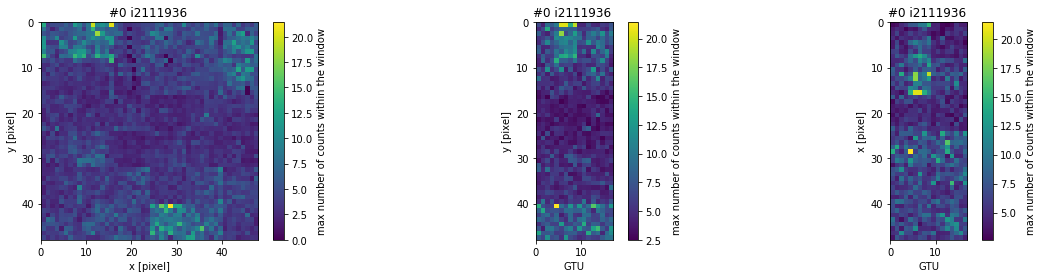

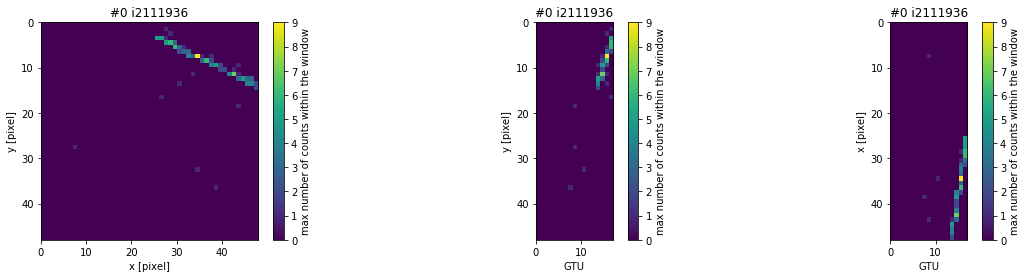

#1	(0)
	event_id: 32492
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 14
	source_file_acquisition: posz_27000000.00/energy_1.12e+12/thousnd27E1.2017-07-24-13h36m26s/npyconv/ev_26_mc_1__signals_p128_a0_g30_f128_b20170503-085415-001.001_k1_s0_d32_n309_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_27000000.00/energy_1.12e+12/thousnd27E1.2017-07-24-13h36m26s/simu2npy/ev_26_mc_1__signals.npy
#1 id: 32492
!!!! simu_gtu_start=-8 simu_gtu_end=6


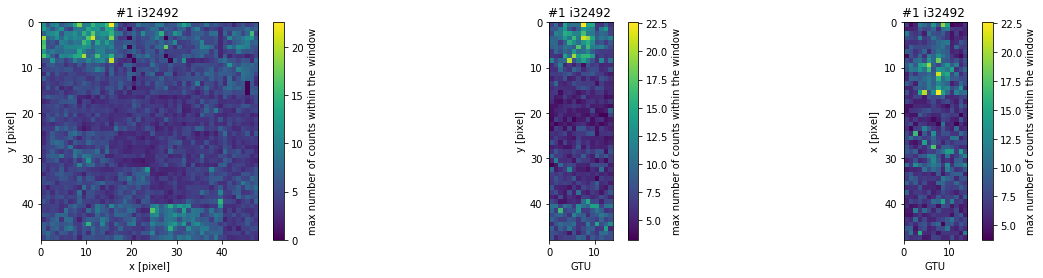

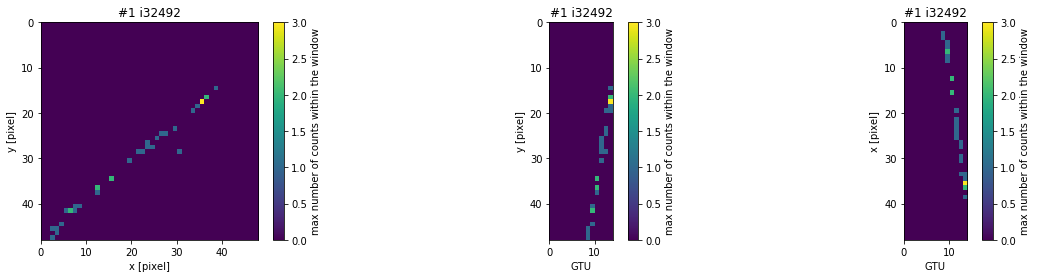

#2	(0)
	event_id: 2078104
	packet_id: 1
	gtu_in_packet: 30
	num_gtu: 11
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h30m11s/npyconv/ev_21_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n383_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h30m11s/simu2npy/ev_21_mc_1__signals.npy
#2 id: 2078104
!!!! simu_gtu_start=-4 simu_gtu_end=7


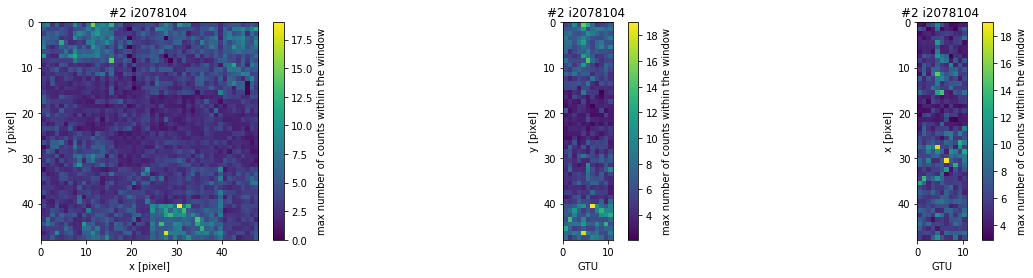

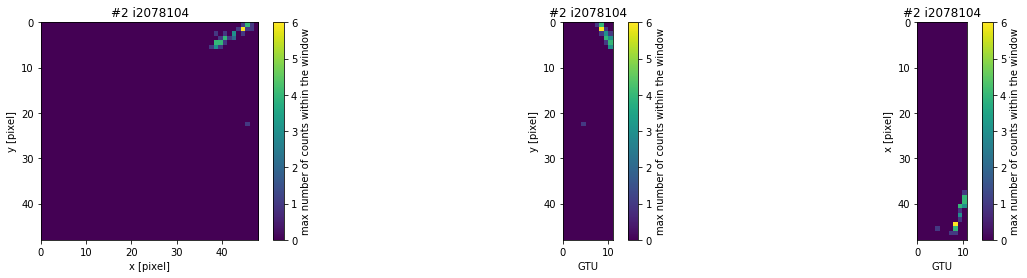

#3	(0)
	event_id: 2078801
	packet_id: 1
	gtu_in_packet: 31
	num_gtu: 9
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h30m11s/npyconv/ev_66_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n392_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h30m11s/simu2npy/ev_66_mc_1__signals.npy
#3 id: 2078801
!!!! simu_gtu_start=-3 simu_gtu_end=6


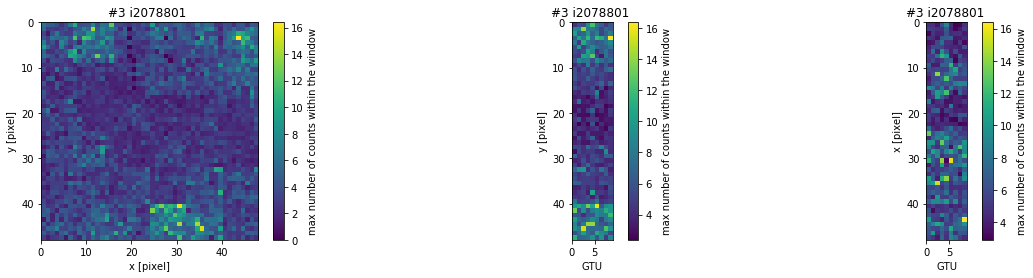

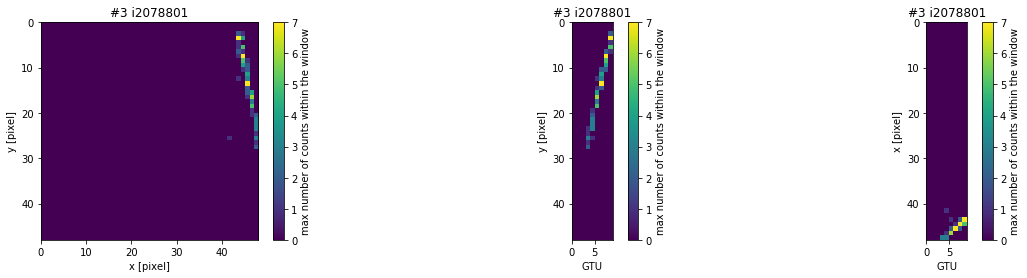

#4	(0)
	event_id: 2081755
	packet_id: 1
	gtu_in_packet: 31
	num_gtu: 15
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h46m04s/npyconv/ev_47_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n431_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-17h46m04s/simu2npy/ev_47_mc_1__signals.npy
#4 id: 2081755
!!!! simu_gtu_start=-3 simu_gtu_end=12


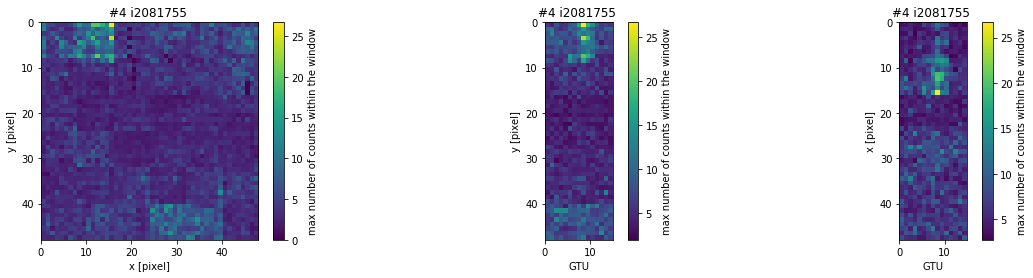

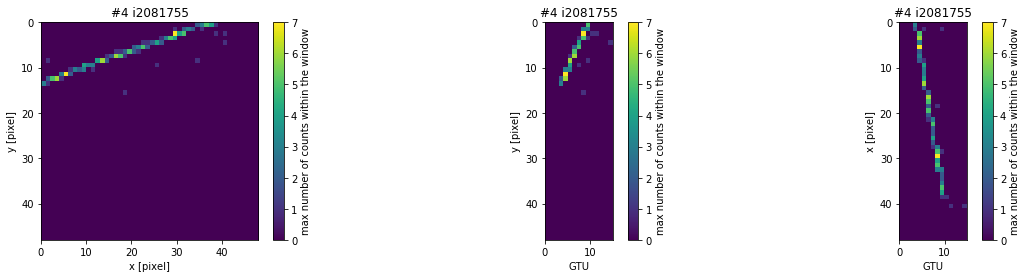

#5	(0)
	event_id: 2082778
	packet_id: 1
	gtu_in_packet: 30
	num_gtu: 18
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n442_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.12e+12/thousnd21E1/simu2npy/ev_0_mc_1__signals.npy
#5 id: 2082778
!!!! simu_gtu_start=-4 simu_gtu_end=14


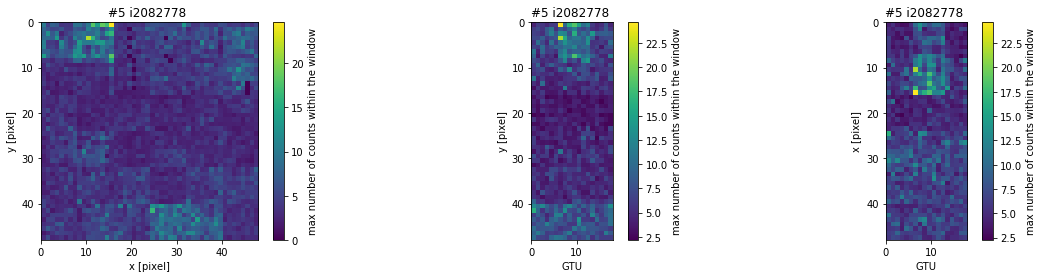

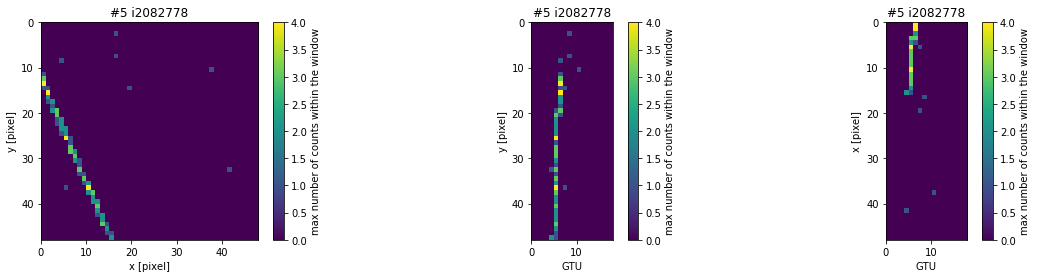

#6	(0)
	event_id: 2131805
	packet_id: 1
	gtu_in_packet: 25
	num_gtu: 15
	source_file_acquisition: posz_18000000.00/energy_1.12e+12/thousnd18E1.2017-07-26-18h54m18s/npyconv/ev_29_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n336_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.12e+12/thousnd18E1.2017-07-26-18h54m18s/simu2npy/ev_29_mc_1__signals.npy
#6 id: 2131805
!!!! simu_gtu_start=-9 simu_gtu_end=6


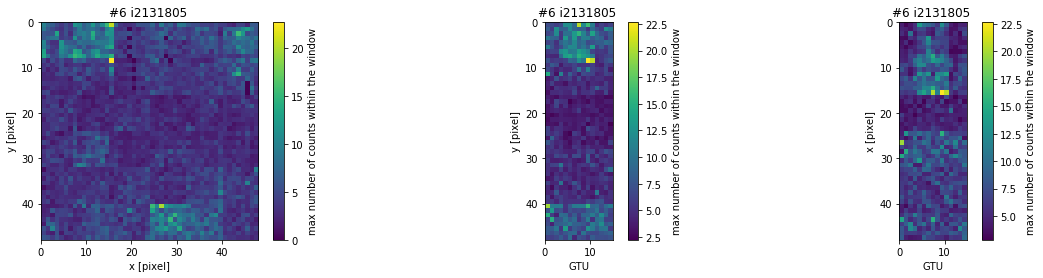

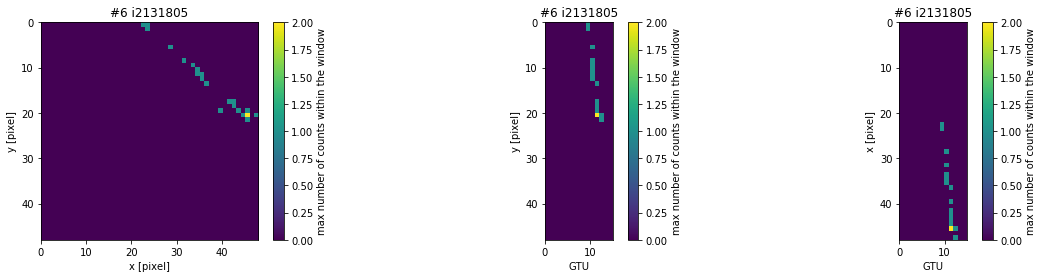

#7	(0)
	event_id: 2072632
	packet_id: 1
	gtu_in_packet: 44
	num_gtu: 12
	source_file_acquisition: posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-16h51m38s/npyconv/ev_12_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n281_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.12e+12/thousnd21E1.2017-07-26-16h51m38s/simu2npy/ev_12_mc_1__signals.npy
#7 id: 2072632
!!!! simu_gtu_start=10 simu_gtu_end=22


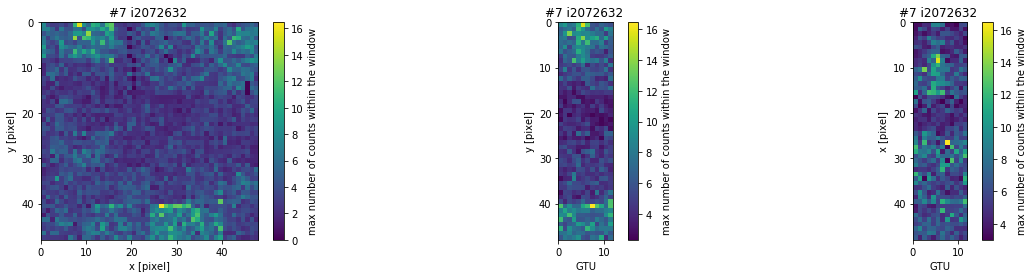

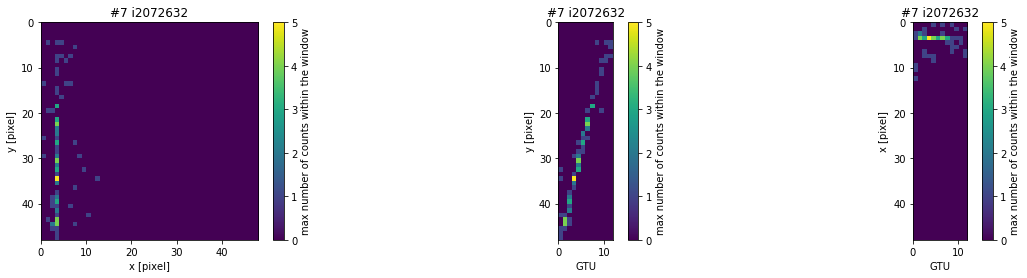

#8	(0)
	event_id: 2155394
	packet_id: 1
	gtu_in_packet: 31
	num_gtu: 10
	source_file_acquisition: posz_18000000.00/energy_1.12e+12/thousnd18E1.2017-07-26-19h54m42s/npyconv/ev_47_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n488_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.12e+12/thousnd18E1.2017-07-26-19h54m42s/simu2npy/ev_47_mc_1__signals.npy
#8 id: 2155394
!!!! simu_gtu_start=-3 simu_gtu_end=7


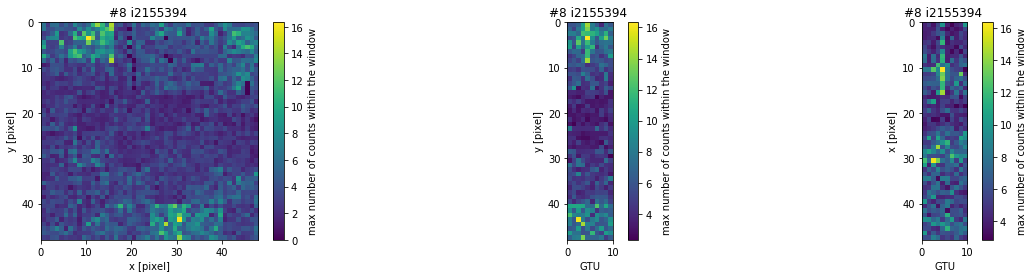

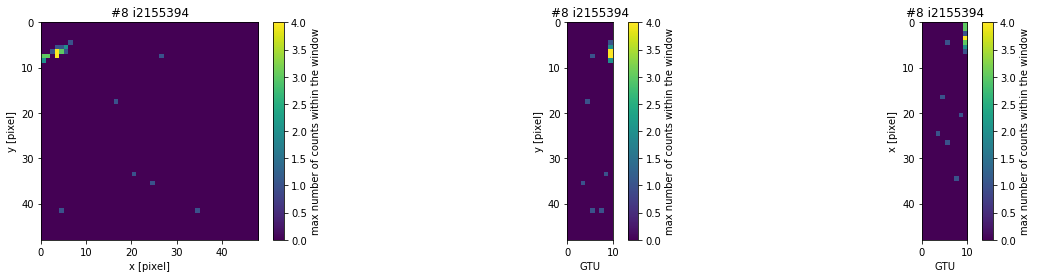

#9	(0)
	event_id: 2147334
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 15
	source_file_acquisition: posz_18000000.00/energy_1.12e+12/thousnd18E1.2017-07-26-19h39m11s/npyconv/ev_21_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n434_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.12e+12/thousnd18E1.2017-07-26-19h39m11s/simu2npy/ev_21_mc_1__signals.npy
#9 id: 2147334
!!!! simu_gtu_start=-1 simu_gtu_end=14


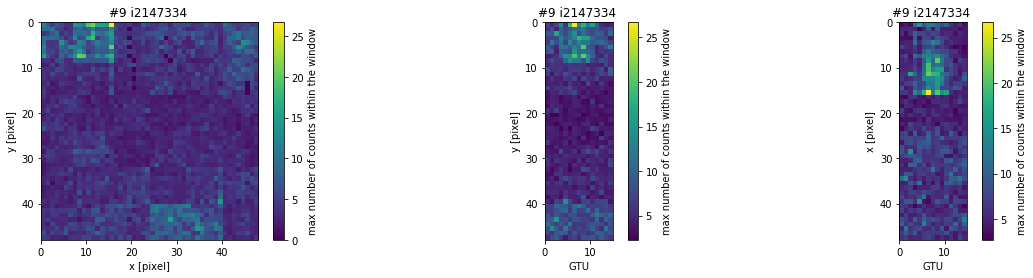

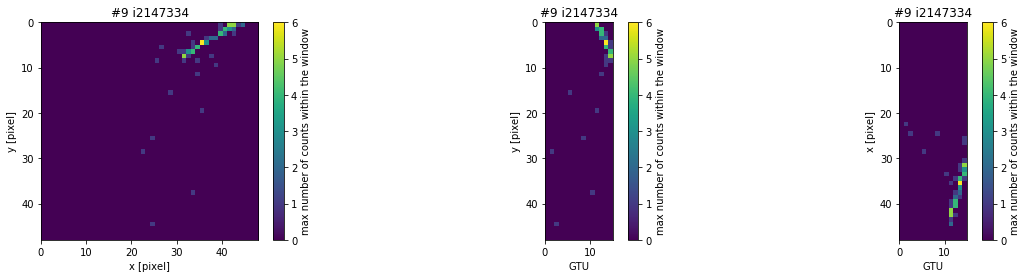

#0	(0)
	event_id: 2547567
	packet_id: 1
	gtu_in_packet: 36
	num_gtu: 13
	source_file_acquisition: posz_33000000.00/energy_1.41e+12/thousnd33E3.2017-07-25-14h44m16s/npyconv/ev_93_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n290_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.41e+12/thousnd33E3.2017-07-25-14h44m16s/simu2npy/ev_93_mc_1__signals.npy
#0 id: 2547567
!!!! simu_gtu_start=2 simu_gtu_end=15


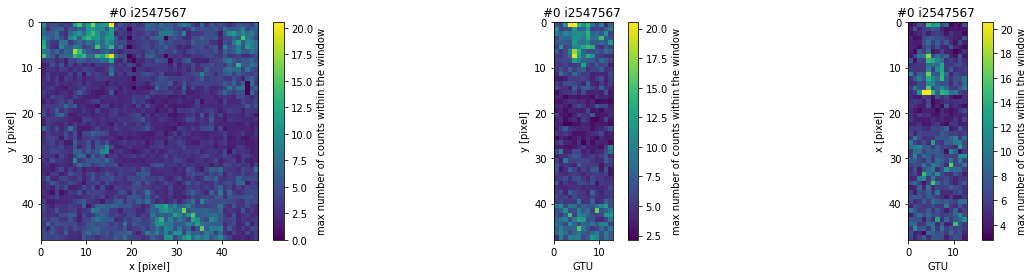

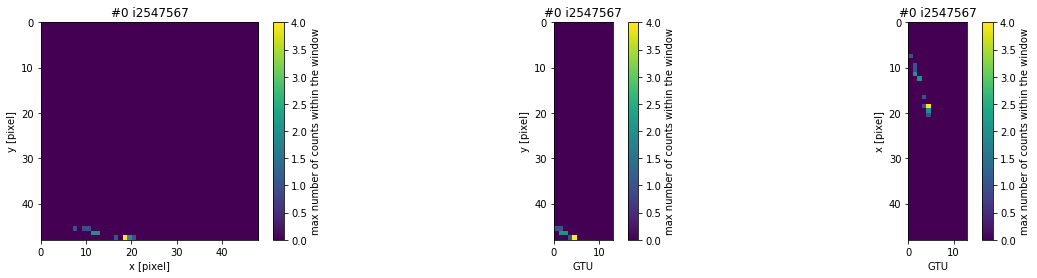

#1	(0)
	event_id: 2105486
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 17
	source_file_acquisition: posz_21000000.00/energy_1.41e+12/thousnd21E3.2017-07-26-19h58m41s/npyconv/ev_2_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n793_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.41e+12/thousnd21E3.2017-07-26-19h58m41s/simu2npy/ev_2_mc_1__signals.npy
#1 id: 2105486
!!!! simu_gtu_start=-8 simu_gtu_end=9


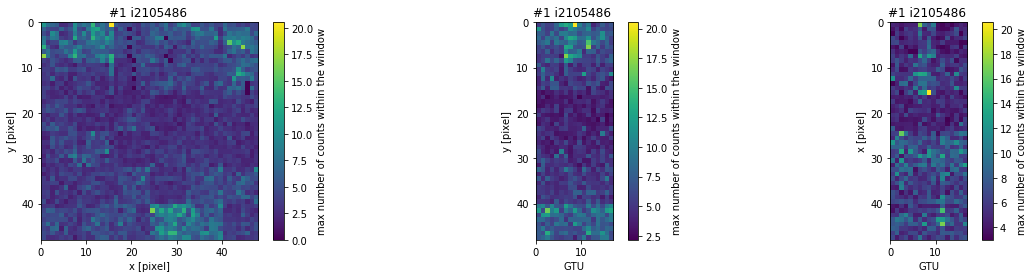

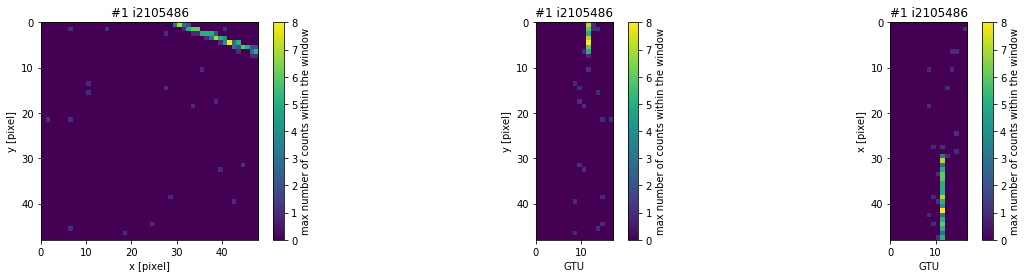

#2	(0)
	event_id: 2547538
	packet_id: 1
	gtu_in_packet: 61
	num_gtu: 12
	source_file_acquisition: posz_33000000.00/energy_1.41e+12/thousnd33E3.2017-07-25-14h44m16s/npyconv/ev_79_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n286_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.41e+12/thousnd33E3.2017-07-25-14h44m16s/simu2npy/ev_79_mc_1__signals.npy
#2 id: 2547538
!!!! simu_gtu_start=27 simu_gtu_end=39


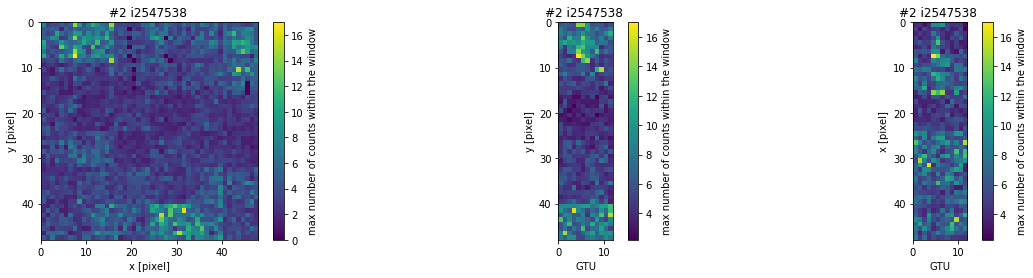

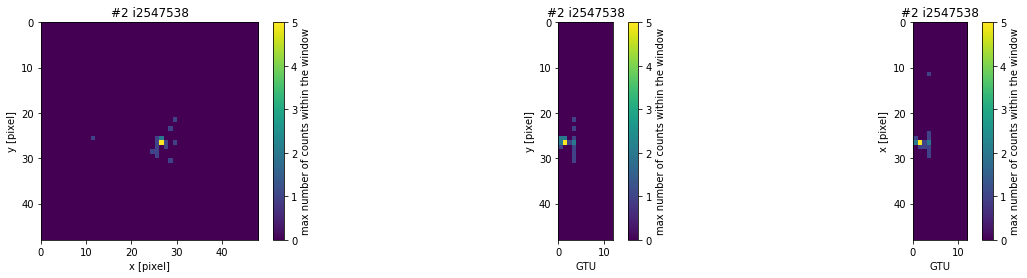

#3	(0)
	event_id: 2084664
	packet_id: 1
	gtu_in_packet: 40
	num_gtu: 14
	source_file_acquisition: posz_30000000.00/energy_1.41e+12/thousnd30E3/npyconv/ev_67_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n323_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.41e+12/thousnd30E3/simu2npy/ev_67_mc_1__signals.npy
#3 id: 2084664
!!!! simu_gtu_start=6 simu_gtu_end=20


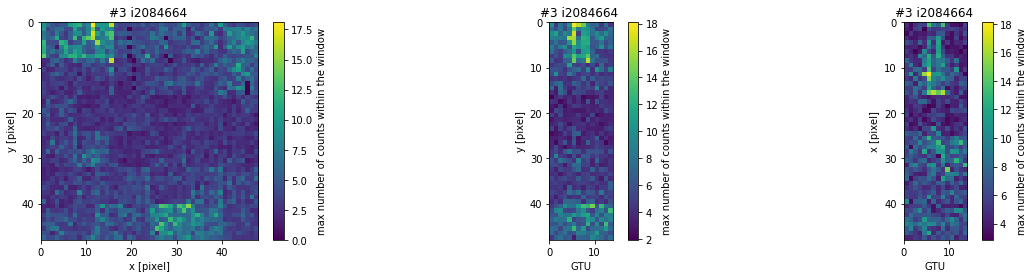

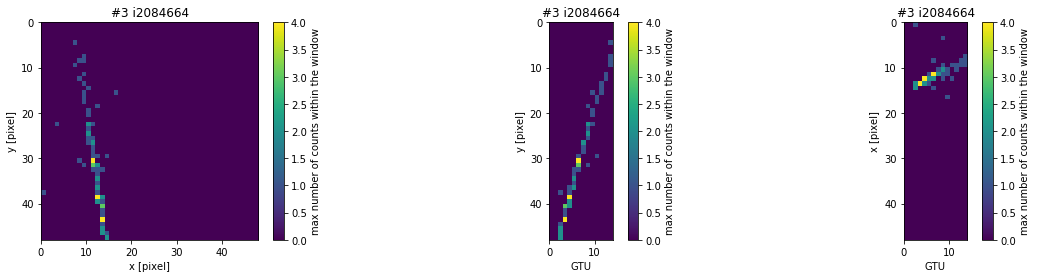

#4	(0)
	event_id: 2193189
	packet_id: 1
	gtu_in_packet: 32
	num_gtu: 10
	source_file_acquisition: posz_18000000.00/energy_1.41e+12/thousnd18E3.2017-07-27-14h56m17s/npyconv/ev_14_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n729_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.41e+12/thousnd18E3.2017-07-27-14h56m17s/simu2npy/ev_14_mc_1__signals.npy
#4 id: 2193189
!!!! simu_gtu_start=-2 simu_gtu_end=8


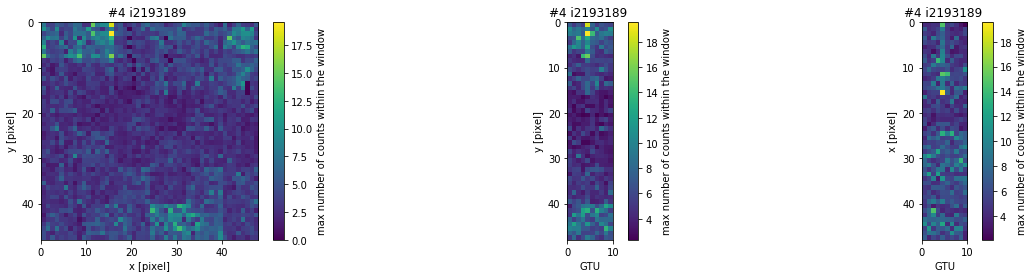

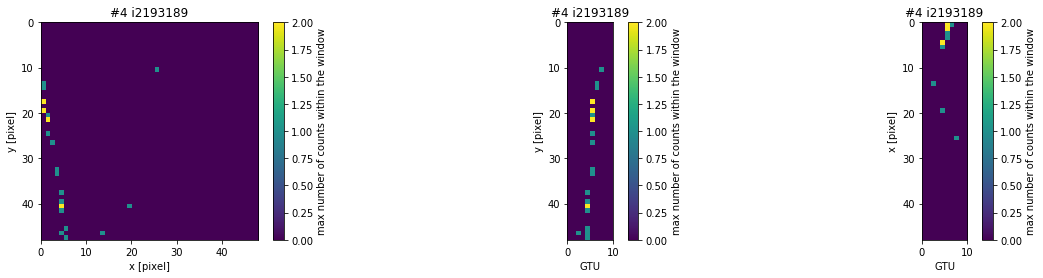

#5	(0)
	event_id: 38735
	packet_id: 1
	gtu_in_packet: 36
	num_gtu: 13
	source_file_acquisition: posz_27000000.00/energy_1.41e+12/thousnd27E3/npyconv/ev_24_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n290_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_27000000.00/energy_1.41e+12/thousnd27E3/simu2npy/ev_24_mc_1__signals.npy
#5 id: 38735
!!!! simu_gtu_start=2 simu_gtu_end=15


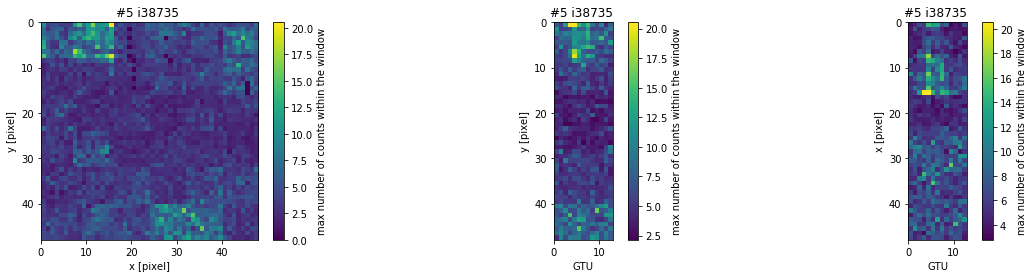

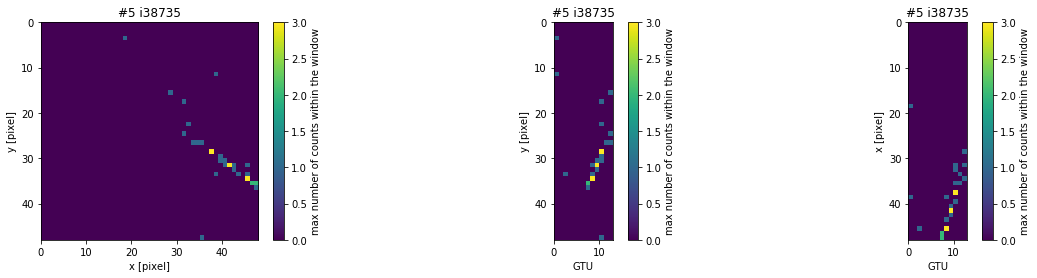

#6	(0)
	event_id: 38702
	packet_id: 1
	gtu_in_packet: 29
	num_gtu: 14
	source_file_acquisition: posz_27000000.00/energy_1.41e+12/thousnd27E3/npyconv/ev_10_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n286_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_27000000.00/energy_1.41e+12/thousnd27E3/simu2npy/ev_10_mc_1__signals.npy
#6 id: 38702
!!!! simu_gtu_start=-5 simu_gtu_end=9


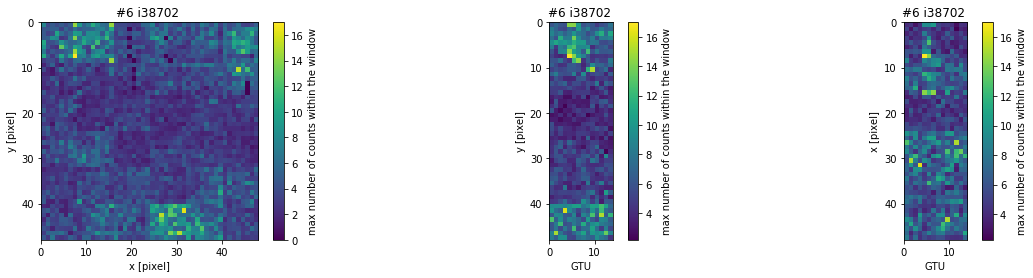

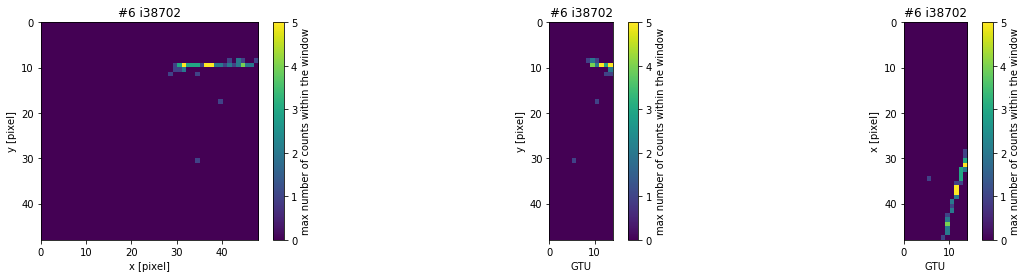

#7	(0)
	event_id: 38265
	packet_id: 1
	gtu_in_packet: 44
	num_gtu: 12
	source_file_acquisition: posz_27000000.00/energy_1.41e+12/thousnd27E3.2017-07-24-16h11m34s/npyconv/ev_83_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n281_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_27000000.00/energy_1.41e+12/thousnd27E3.2017-07-24-16h11m34s/simu2npy/ev_83_mc_1__signals.npy
#7 id: 38265
!!!! simu_gtu_start=10 simu_gtu_end=22


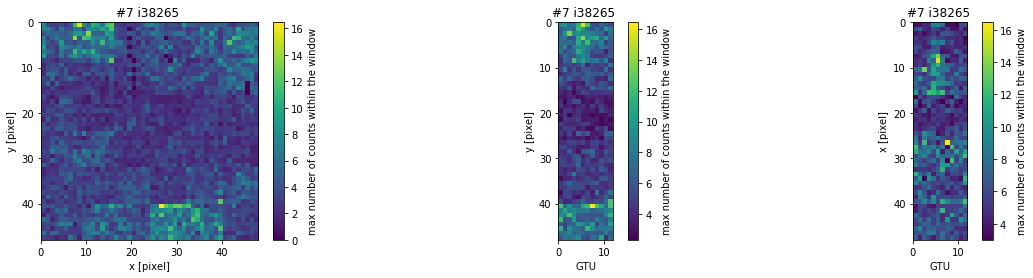

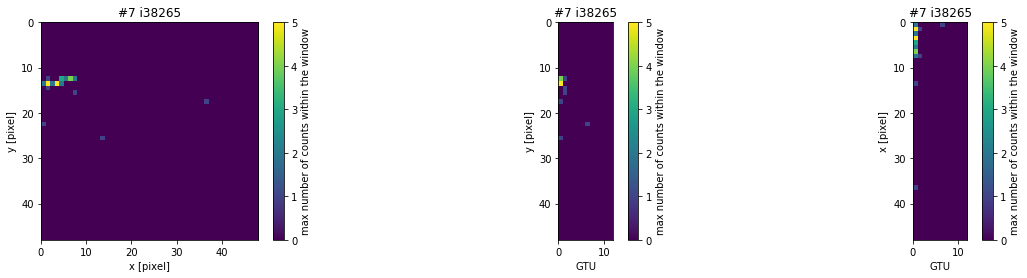

#8	(0)
	event_id: 35891
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 14
	source_file_acquisition: posz_27000000.00/energy_1.41e+12/thousnd27E3.2017-07-24-15h49m12s/npyconv/ev_89_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n197_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_27000000.00/energy_1.41e+12/thousnd27E3.2017-07-24-15h49m12s/simu2npy/ev_89_mc_1__signals.npy
#8 id: 35891
!!!! simu_gtu_start=-1 simu_gtu_end=13


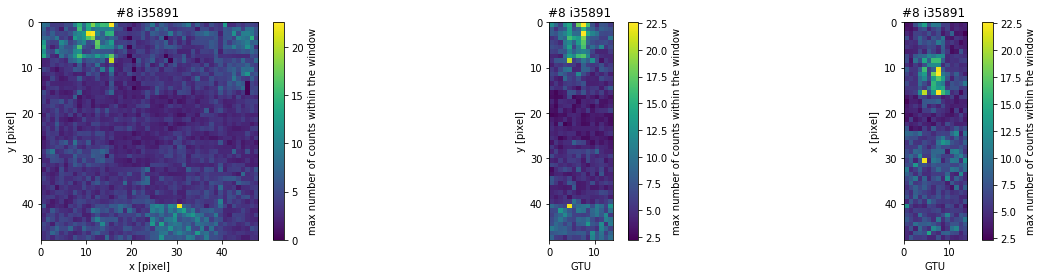

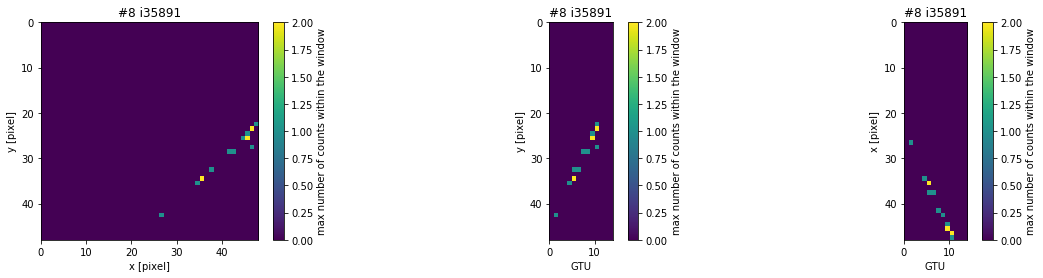

#9	(0)
	event_id: 2071967
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 17
	source_file_acquisition: posz_30000000.00/energy_1.41e+12/thousnd30E3.2017-07-24-19h31m35s/npyconv/ev_3_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n210_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.41e+12/thousnd30E3.2017-07-24-19h31m35s/simu2npy/ev_3_mc_1__signals.npy
#9 id: 2071967
!!!! simu_gtu_start=-7 simu_gtu_end=10


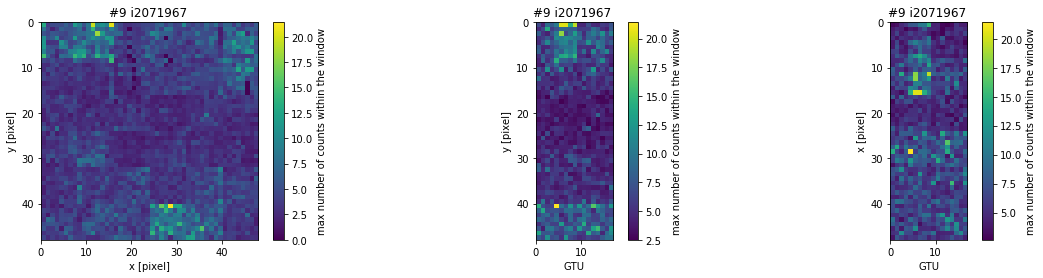

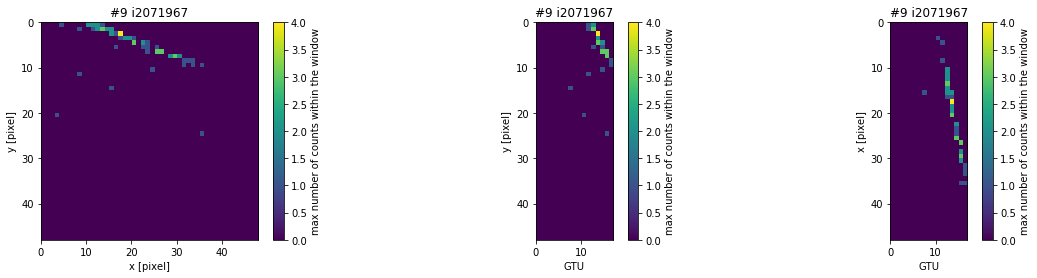

#0	(0)
	event_id: 2554842
	packet_id: 1
	gtu_in_packet: 25
	num_gtu: 15
	source_file_acquisition: posz_33000000.00/energy_1.58e+12/thousnd33E4.2017-07-25-15h54m45s/npyconv/ev_66_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n536_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.58e+12/thousnd33E4.2017-07-25-15h54m45s/simu2npy/ev_66_mc_1__signals.npy
#0 id: 2554842
!!!! simu_gtu_start=-9 simu_gtu_end=6


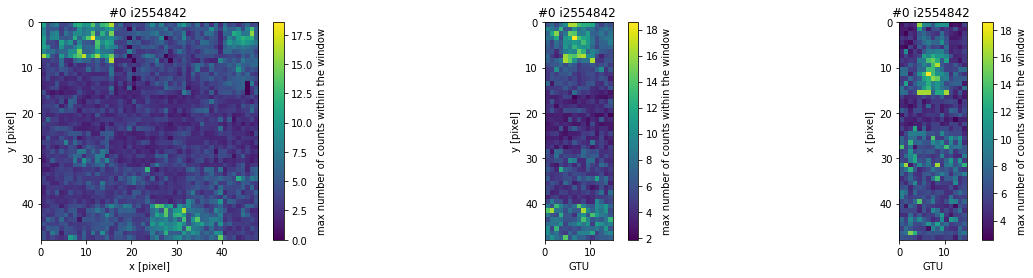

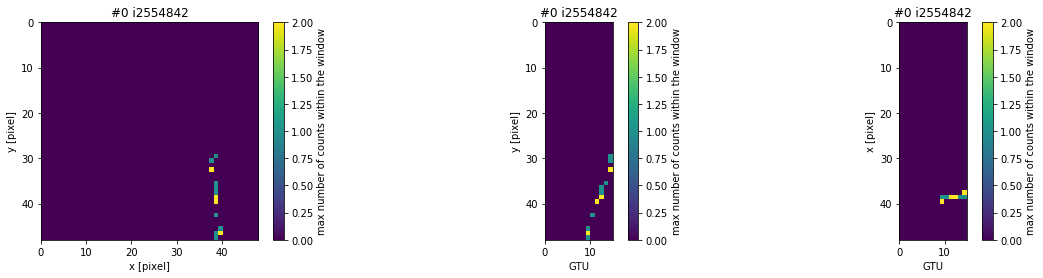

#1	(0)
	event_id: 2555313
	packet_id: 1
	gtu_in_packet: 29
	num_gtu: 12
	source_file_acquisition: posz_33000000.00/energy_1.58e+12/thousnd33E4.2017-07-25-16h02m32s/npyconv/ev_26_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n552_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.58e+12/thousnd33E4.2017-07-25-16h02m32s/simu2npy/ev_26_mc_1__signals.npy
#1 id: 2555313
!!!! simu_gtu_start=-5 simu_gtu_end=7


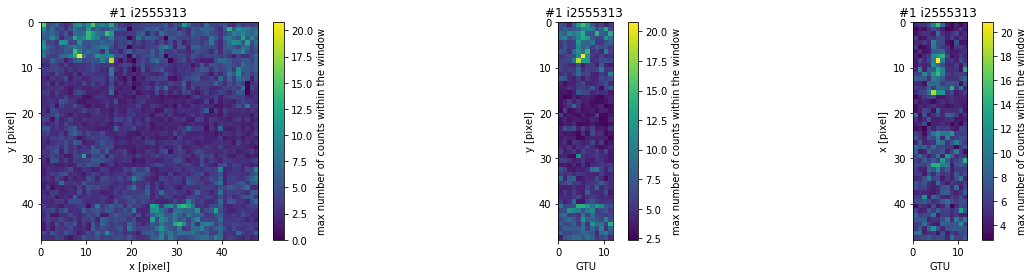

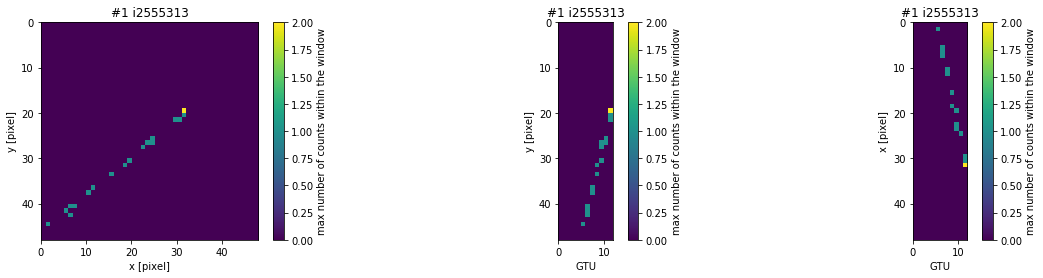

#2	(0)
	event_id: 2555936
	packet_id: 1
	gtu_in_packet: 19
	num_gtu: 18
	source_file_acquisition: posz_33000000.00/energy_1.58e+12/thousnd33E4.2017-07-25-16h10m32s/npyconv/ev_14_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n579_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.58e+12/thousnd33E4.2017-07-25-16h10m32s/simu2npy/ev_14_mc_1__signals.npy
#2 id: 2555936
!!!! simu_gtu_start=-15 simu_gtu_end=3


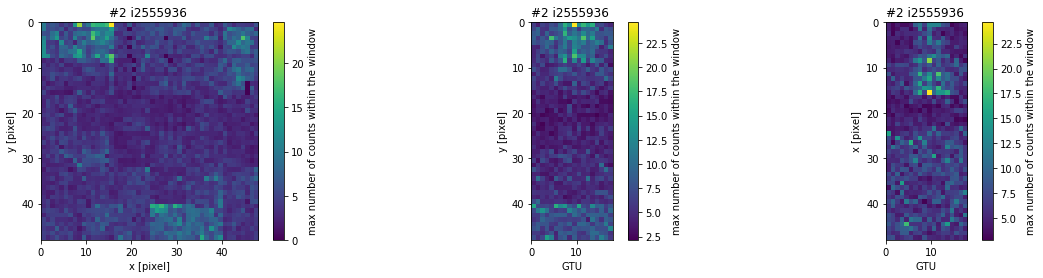

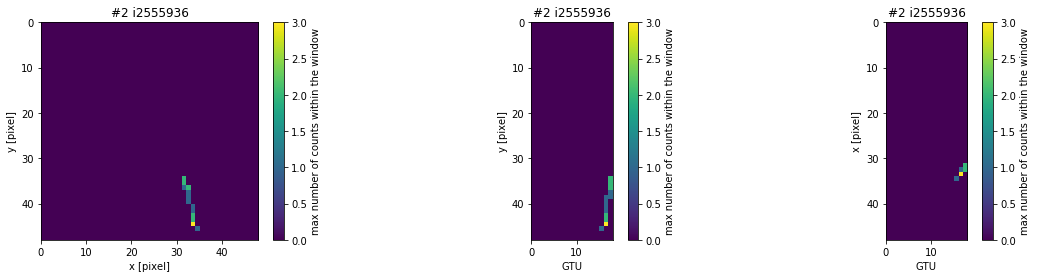

#3	(0)
	event_id: 2556751
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 11
	source_file_acquisition: posz_33000000.00/energy_1.58e+12/thousnd33E4/npyconv/ev_89_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n630_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.58e+12/thousnd33E4/simu2npy/ev_89_mc_1__signals.npy
#3 id: 2556751
!!!! simu_gtu_start=-1 simu_gtu_end=10


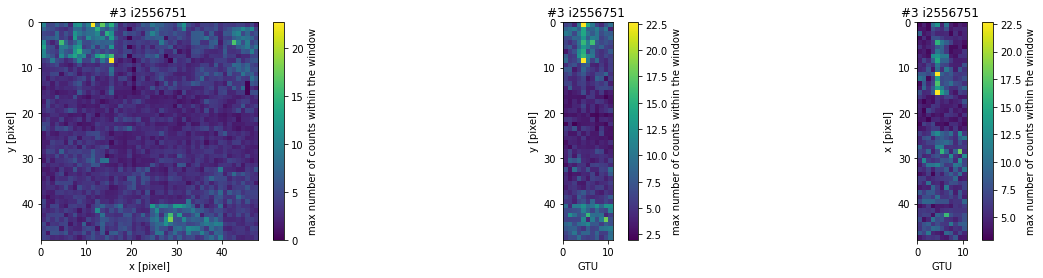

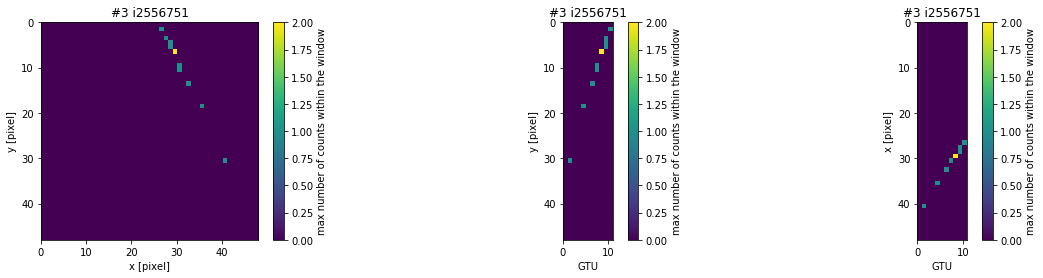

#4	(0)
	event_id: 2087868
	packet_id: 1
	gtu_in_packet: 28
	num_gtu: 12
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-20h09m52s/npyconv/ev_38_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n349_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-20h09m52s/simu2npy/ev_38_mc_1__signals.npy
#4 id: 2087868
!!!! simu_gtu_start=-6 simu_gtu_end=6


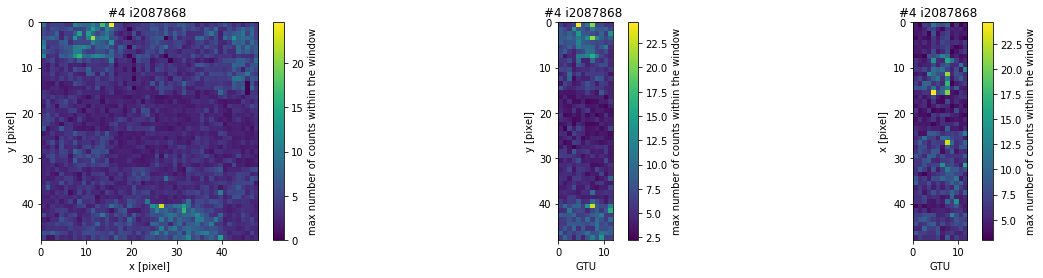

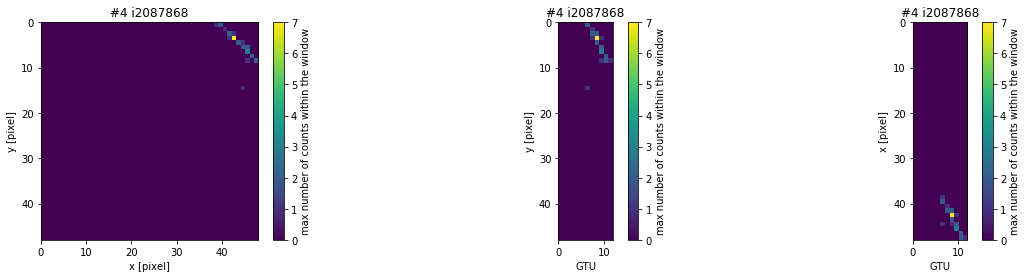

#5	(0)
	event_id: 2102407
	packet_id: 1
	gtu_in_packet: 29
	num_gtu: 11
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-20h40m15s/npyconv/ev_92_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n459_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-20h40m15s/simu2npy/ev_92_mc_1__signals.npy
#5 id: 2102407
!!!! simu_gtu_start=-5 simu_gtu_end=6


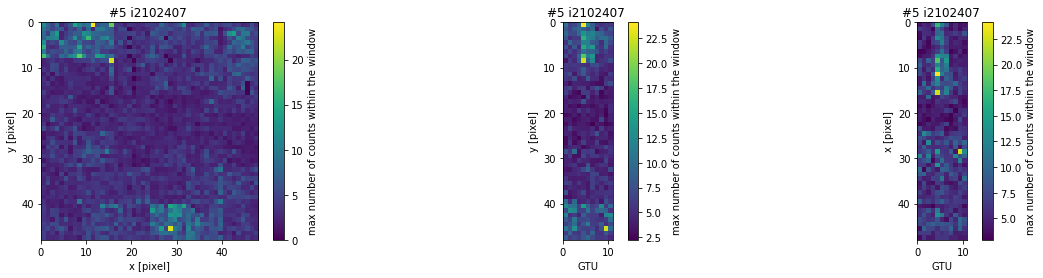

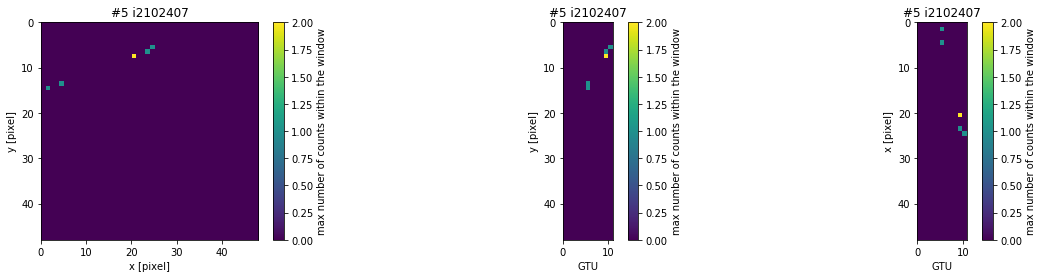

#6	(0)
	event_id: 2099226
	packet_id: 1
	gtu_in_packet: 33
	num_gtu: 15
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-20h33m37s/npyconv/ev_74_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n434_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-20h33m37s/simu2npy/ev_74_mc_1__signals.npy
#6 id: 2099226
!!!! simu_gtu_start=-1 simu_gtu_end=14


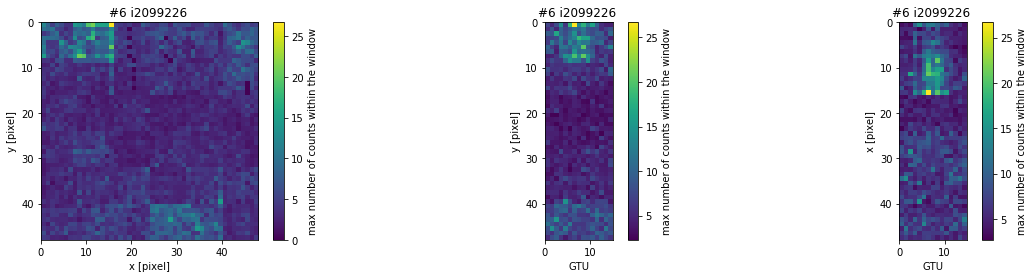

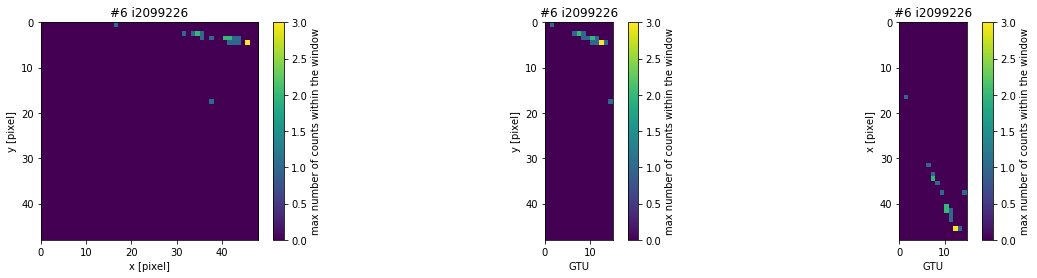

#7	(0)
	event_id: 2110182
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 16
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/npyconv/ev_26_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n524_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/simu2npy/ev_26_mc_1__signals.npy
#7 id: 2110182
!!!! simu_gtu_start=-7 simu_gtu_end=9


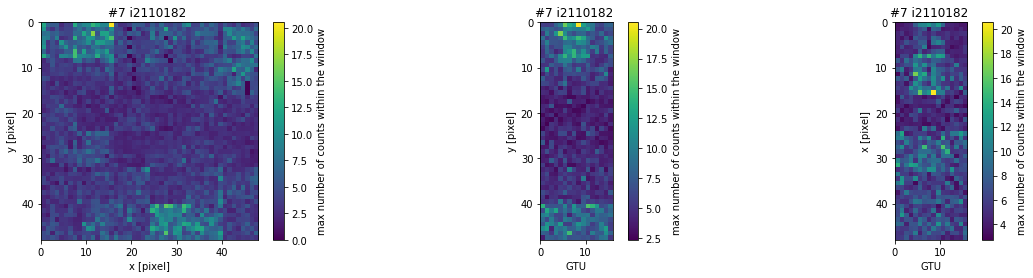

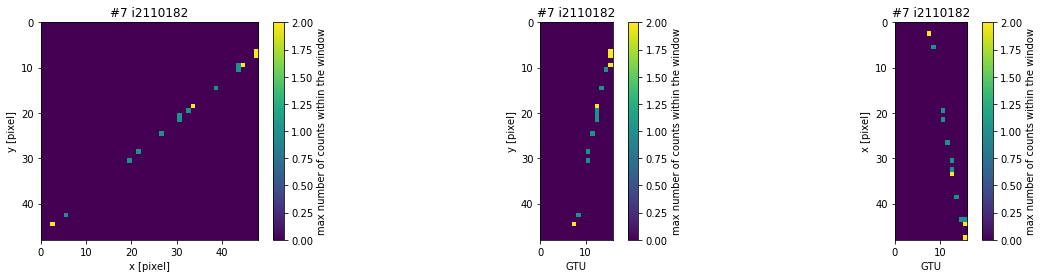

#8	(0)
	event_id: 2111839
	packet_id: 1
	gtu_in_packet: 57
	num_gtu: 15
	source_file_acquisition: posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/npyconv/ev_65_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n536_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.58e+12/thousnd30E4.2017-07-24-21h02m30s/simu2npy/ev_65_mc_1__signals.npy
#8 id: 2111839
!!!! simu_gtu_start=23 simu_gtu_end=38


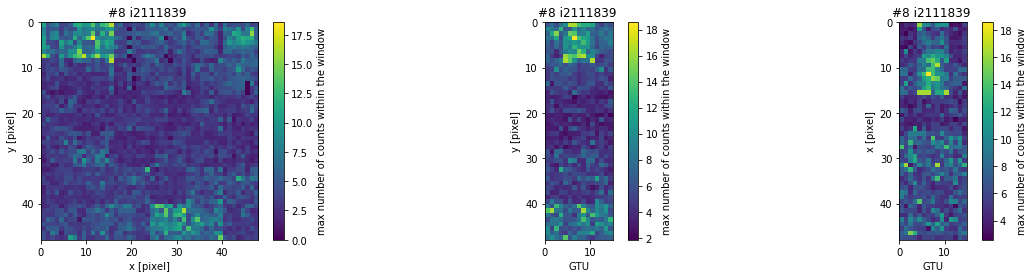

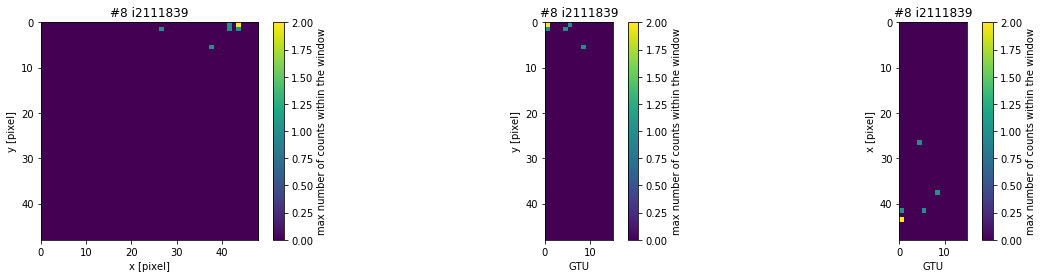

#9	(0)
	event_id: 2115141
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 14
	source_file_acquisition: posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-20h53m09s/npyconv/ev_10_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n961_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-20h53m09s/simu2npy/ev_10_mc_1__signals.npy
#9 id: 2115141
!!!! simu_gtu_start=-7 simu_gtu_end=7


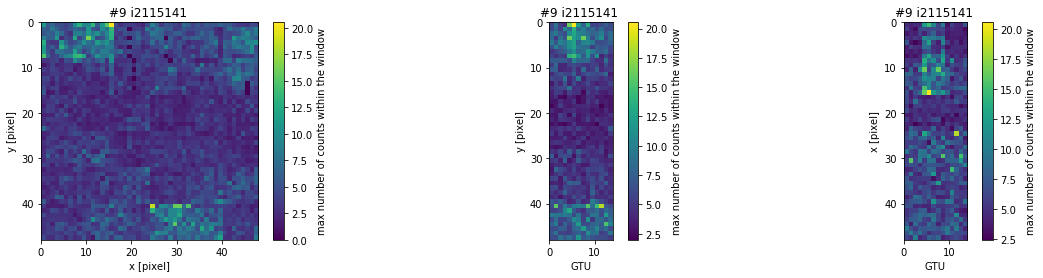

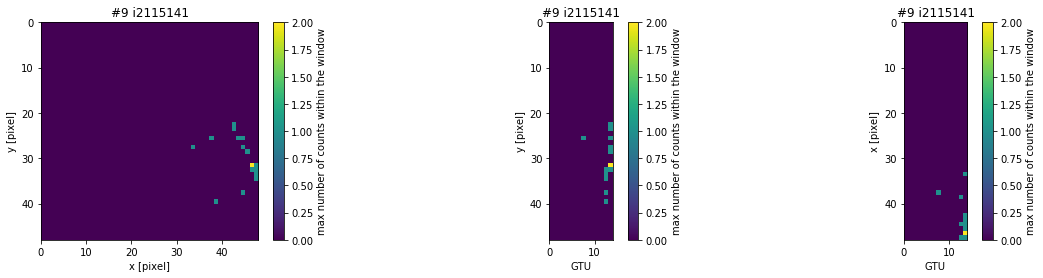

#0	(0)
	event_id: 2134551
	packet_id: 1
	gtu_in_packet: 30
	num_gtu: 16
	source_file_acquisition: posz_21000000.00/energy_1.78e+12/thousnd21E5.2017-07-27-15h50m34s/npyconv/ev_66_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n1299_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.78e+12/thousnd21E5.2017-07-27-15h50m34s/simu2npy/ev_66_mc_1__signals.npy
#0 id: 2134551
!!!! simu_gtu_start=-4 simu_gtu_end=12


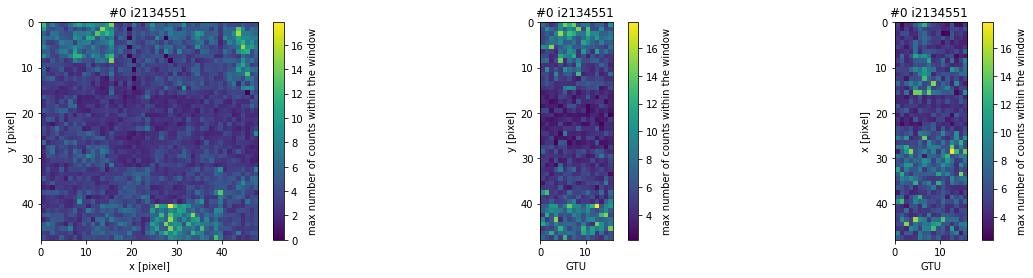

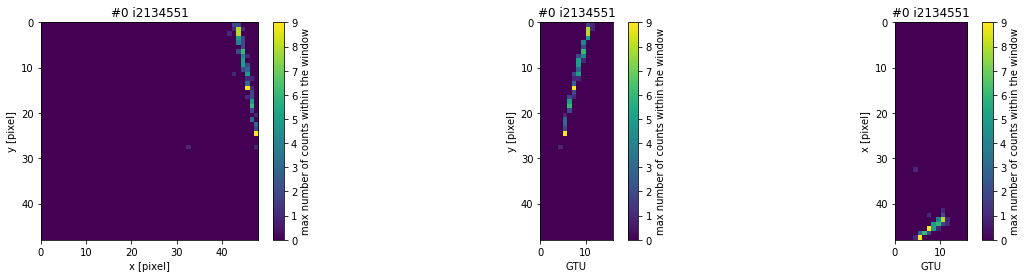

#1	(0)
	event_id: 2568638
	packet_id: 1
	gtu_in_packet: 28
	num_gtu: 11
	source_file_acquisition: posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h20m09s/npyconv/ev_86_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n834_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h20m09s/simu2npy/ev_86_mc_1__signals.npy
#1 id: 2568638
!!!! simu_gtu_start=-6 simu_gtu_end=5


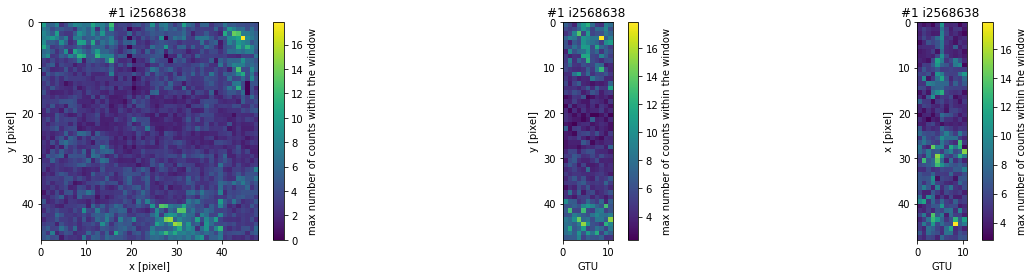

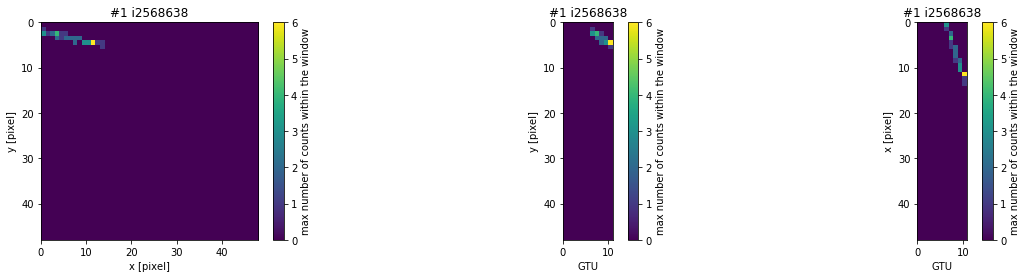

#2	(0)
	event_id: 2140147
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 14
	source_file_acquisition: posz_30000000.00/energy_1.78e+12/thousnd30E5.2017-07-24-22h10m05s/npyconv/ev_66_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n778_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.78e+12/thousnd30E5.2017-07-24-22h10m05s/simu2npy/ev_66_mc_1__signals.npy
#2 id: 2140147
!!!! simu_gtu_start=-7 simu_gtu_end=7


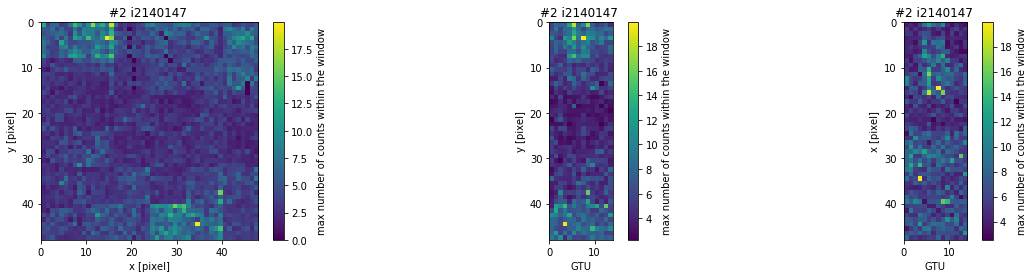

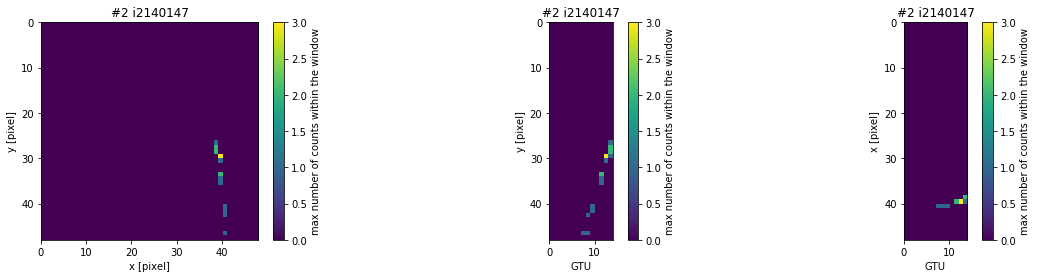

#3	(0)
	event_id: 2142326
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 14
	source_file_acquisition: posz_30000000.00/energy_1.78e+12/thousnd30E5.2017-07-24-22h17m44s/npyconv/ev_26_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n793_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.78e+12/thousnd30E5.2017-07-24-22h17m44s/simu2npy/ev_26_mc_1__signals.npy
#3 id: 2142326
!!!! simu_gtu_start=-8 simu_gtu_end=6


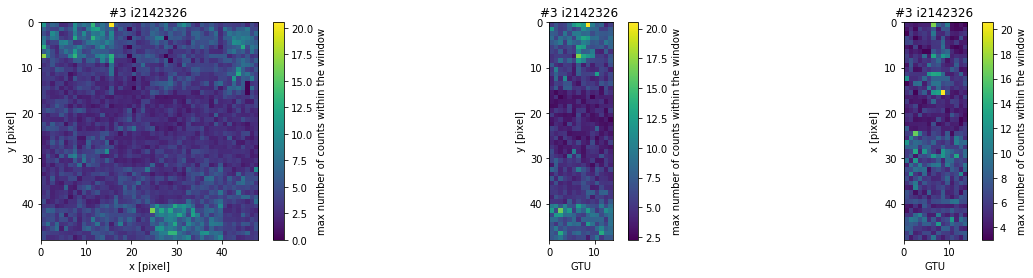

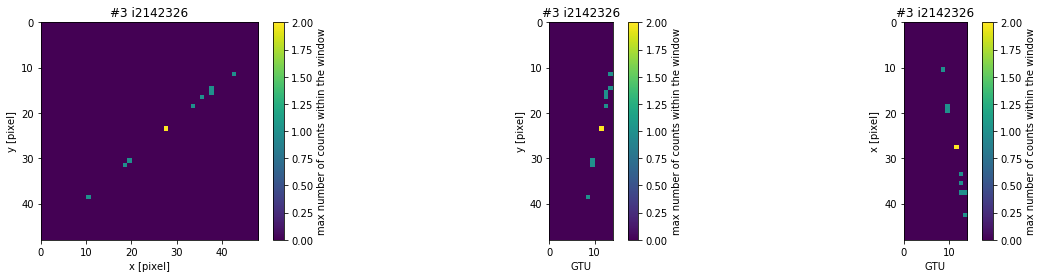

#4	(0)
	event_id: 2568832
	packet_id: 1
	gtu_in_packet: 27
	num_gtu: 13
	source_file_acquisition: posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h28m05s/npyconv/ev_27_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n844_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_33000000.00/energy_1.78e+12/thousnd33E5.2017-07-25-17h28m05s/simu2npy/ev_27_mc_1__signals.npy
#4 id: 2568832
!!!! simu_gtu_start=-7 simu_gtu_end=6


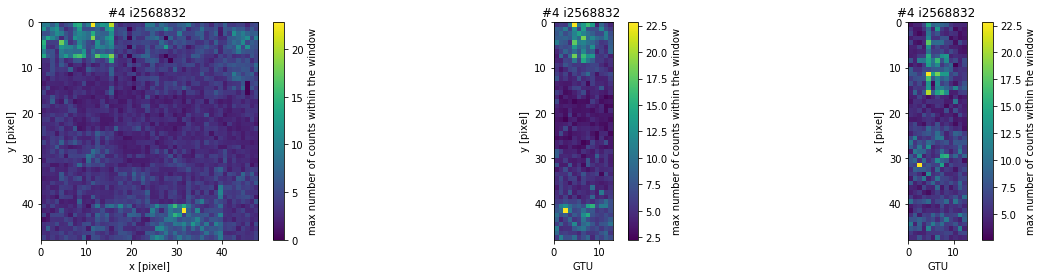

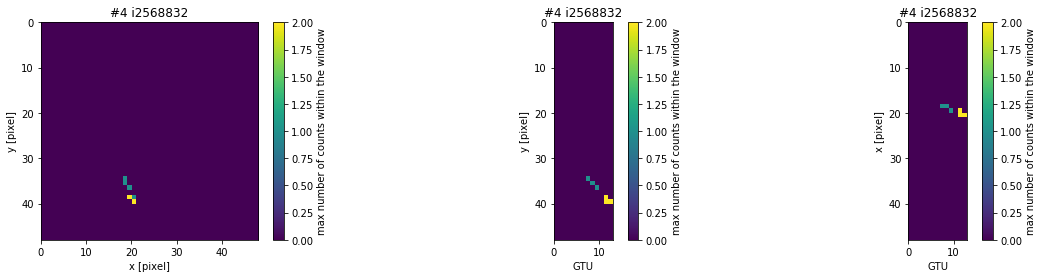

#5	(0)
	event_id: 2145557
	packet_id: 1
	gtu_in_packet: 31
	num_gtu: 19
	source_file_acquisition: posz_30000000.00/energy_1.78e+12/thousnd30E5.2017-07-24-22h25m32s/npyconv/ev_47_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n825_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.78e+12/thousnd30E5.2017-07-24-22h25m32s/simu2npy/ev_47_mc_1__signals.npy
#5 id: 2145557
!!!! simu_gtu_start=-3 simu_gtu_end=16


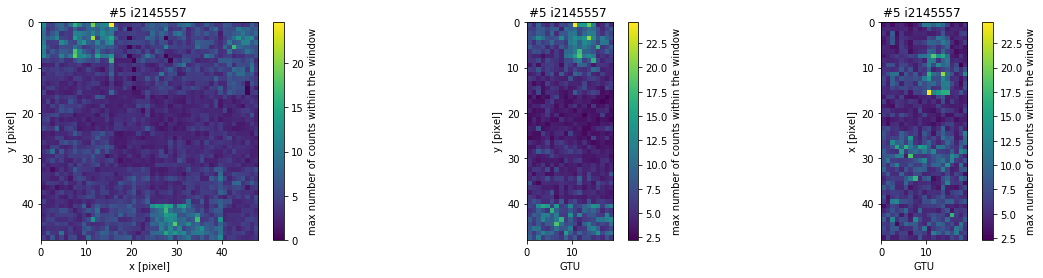

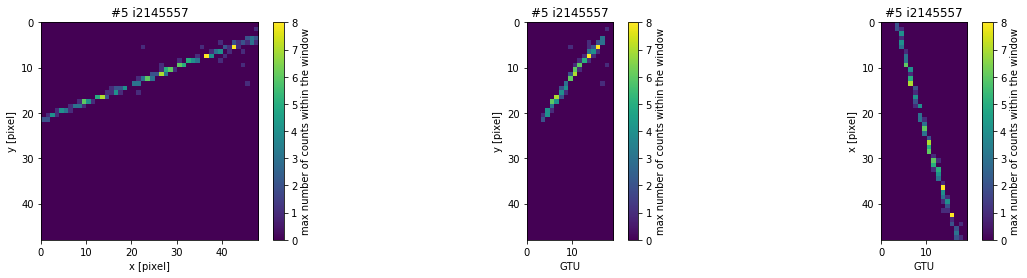

#6	(0)
	event_id: 2142530
	packet_id: 1
	gtu_in_packet: 36
	num_gtu: 14
	source_file_acquisition: posz_30000000.00/energy_1.78e+12/thousnd30E5.2017-07-24-22h17m44s/npyconv/ev_29_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n796_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.78e+12/thousnd30E5.2017-07-24-22h17m44s/simu2npy/ev_29_mc_1__signals.npy
#6 id: 2142530
!!!! simu_gtu_start=2 simu_gtu_end=16


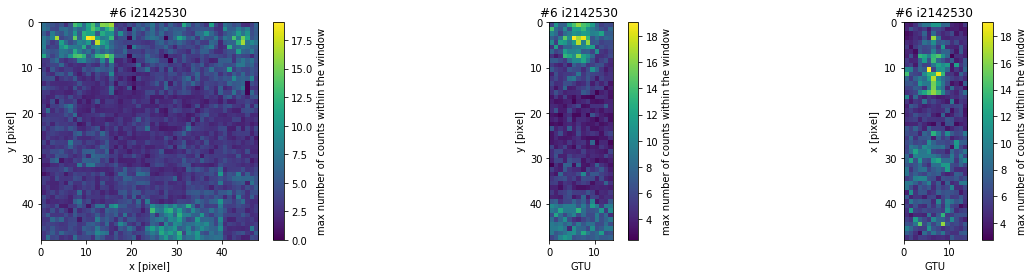

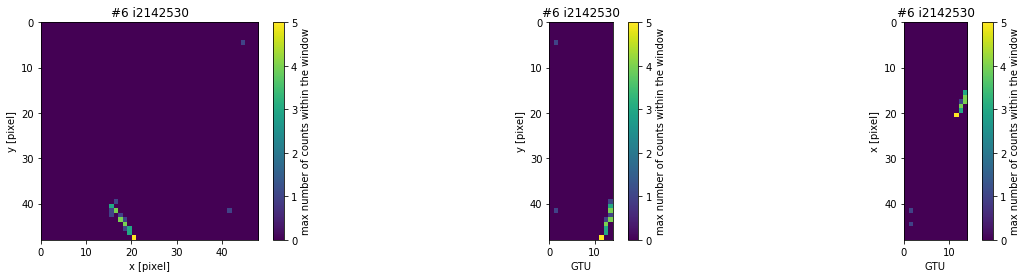

#7	(0)
	event_id: 2148315
	packet_id: 1
	gtu_in_packet: 26
	num_gtu: 14
	source_file_acquisition: posz_30000000.00/energy_1.78e+12/thousnd30E5/npyconv/ev_0_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n845_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.78e+12/thousnd30E5/simu2npy/ev_0_mc_1__signals.npy
#7 id: 2148315
!!!! simu_gtu_start=-8 simu_gtu_end=6


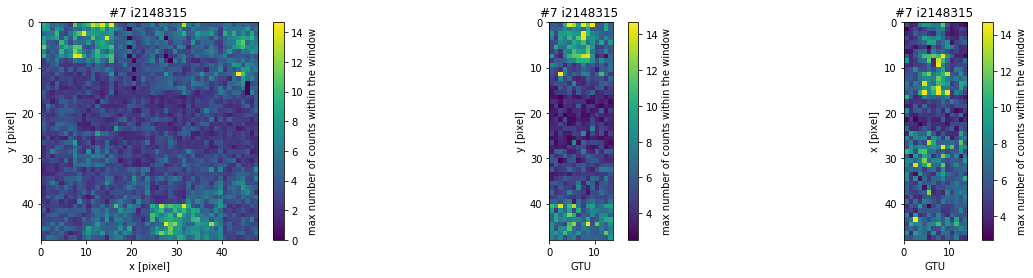

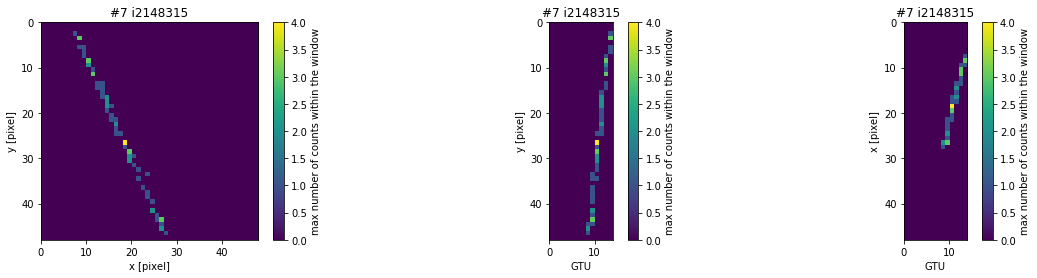

#8	(0)
	event_id: 2150085
	packet_id: 1
	gtu_in_packet: 29
	num_gtu: 12
	source_file_acquisition: posz_30000000.00/energy_1.78e+12/thousnd30E5/npyconv/ev_74_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n869_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_1.78e+12/thousnd30E5/simu2npy/ev_74_mc_1__signals.npy
#8 id: 2150085
!!!! simu_gtu_start=-5 simu_gtu_end=7


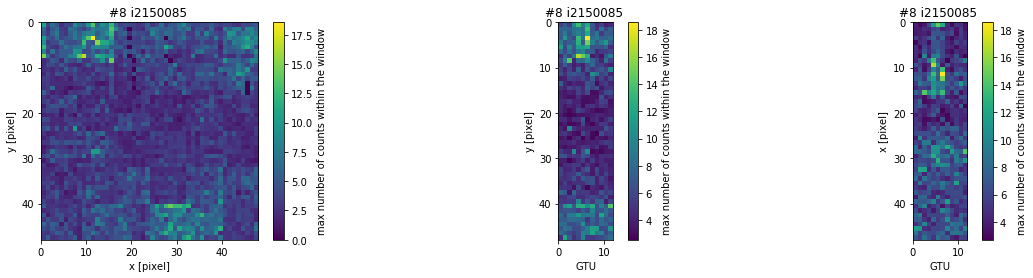

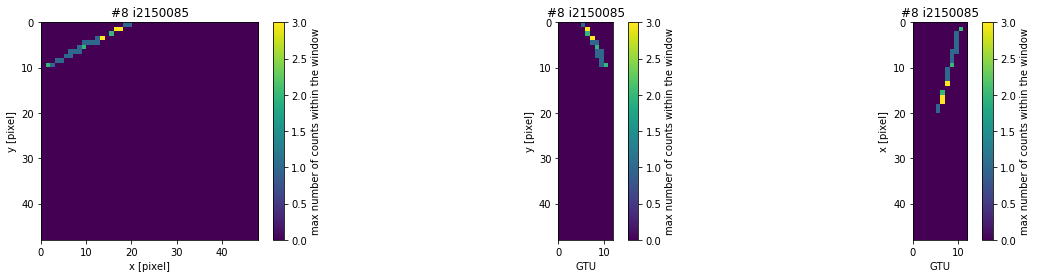

#9	(0)
	event_id: 142771
	packet_id: 1
	gtu_in_packet: 44
	num_gtu: 16
	source_file_acquisition: posz_24000000.00/energy_1.90e+12/simu.2017-07-14-16h26m02s/npyconv/ev_9_mc_1__signals_p128_a0_g30_f128_b20170429-120553-002.001_k1_s0_d32_n166_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_24000000.00/energy_1.90e+12/simu.2017-07-14-16h26m02s/simu2npy/ev_9_mc_1__signals.npy
#9 id: 142771
!!!! simu_gtu_start=10 simu_gtu_end=26


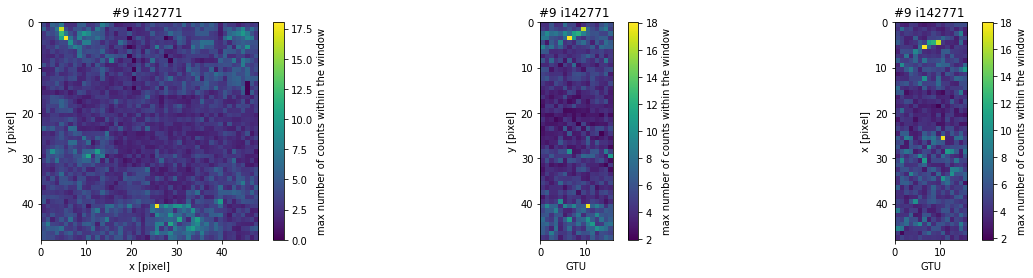

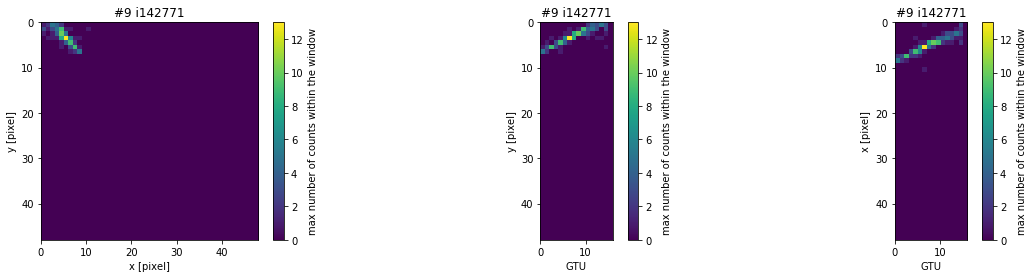

#0	(0)
	event_id: 2189486
	packet_id: 1
	gtu_in_packet: 28
	num_gtu: 12
	source_file_acquisition: posz_30000000.00/energy_2.24e+12/thousnd30E7.2017-07-25-00h22m20s/npyconv/ev_69_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n1325_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_30000000.00/energy_2.24e+12/thousnd30E7.2017-07-25-00h22m20s/simu2npy/ev_69_mc_1__signals.npy
#0 id: 2189486
!!!! simu_gtu_start=-6 simu_gtu_end=6


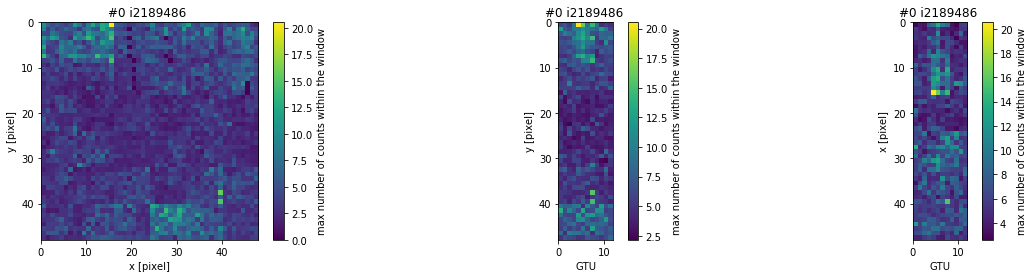

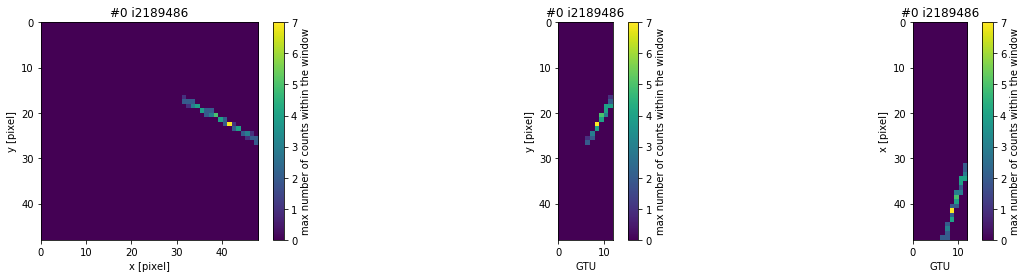

#1	(0)
	event_id: 68019
	packet_id: 1
	gtu_in_packet: 28
	num_gtu: 15
	source_file_acquisition: posz_27000000.00/energy_2.24e+12/thousnd27E7.2017-07-24-21h01m46s/npyconv/ev_49_mc_1__signals_p128_a0_g30_f128_b20170428-092901-001.001_k1_s0_d32_n1373_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_27000000.00/energy_2.24e+12/thousnd27E7.2017-07-24-21h01m46s/simu2npy/ev_49_mc_1__signals.npy
#1 id: 68019
!!!! simu_gtu_start=-6 simu_gtu_end=9


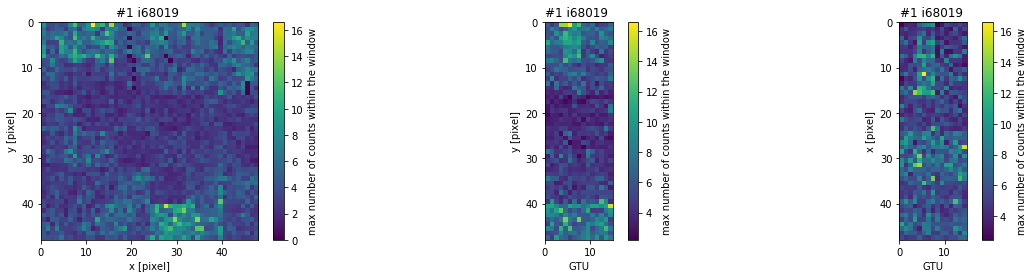

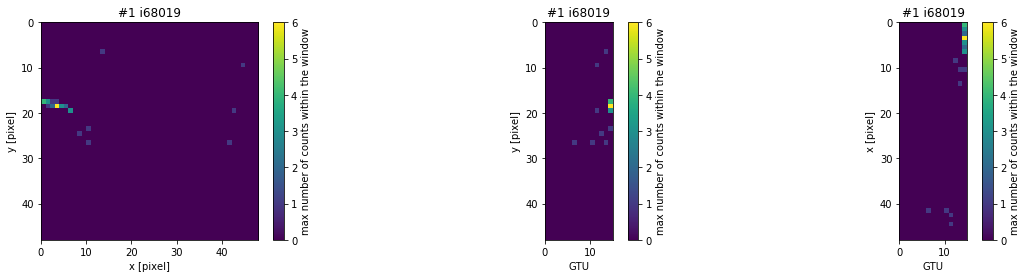

#2	(0)
	event_id: 2451105
	packet_id: 1
	gtu_in_packet: 43
	num_gtu: 17
	source_file_acquisition: posz_18000000.00/energy_2.40e+12/simu.2017-07-15-20h50m24s/npyconv/ev_9_mc_1__signals_p128_a0_g30_f128_b20170429-080135-025.001_k1_s0_d32_n39_m128_Cinverse_flat_average_directions_4m_flipud.npy
	simu2npy_signals_pathname: /mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_18000000.00/energy_2.40e+12/simu.2017-07-15-20h50m24s/simu2npy/ev_9_mc_1__signals.npy
#2 id: 2451105
!!!! simu_gtu_start=9 simu_gtu_end=26


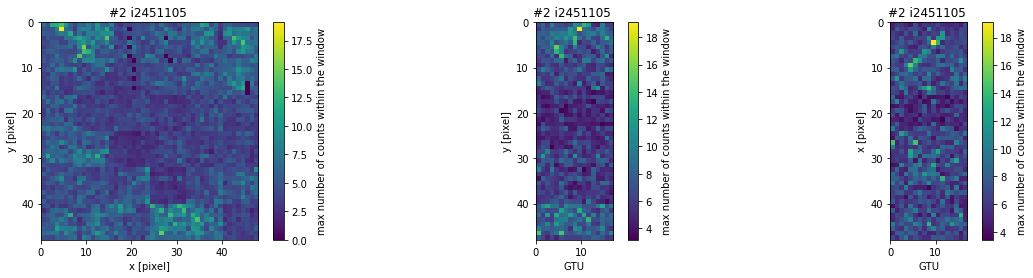

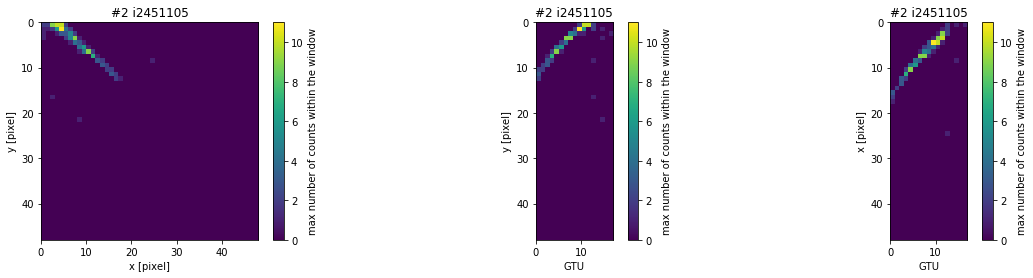

In [225]:
events_to_vis_df = simu_bgf1_tracks_nonan__insensitive__df.sort_values(['etruth_trueenergy'], ascending=[True])

single_proj_width=6 
single_proj_height=4
line_alpha=0.0


print('len(events_to_vis_df) =', len(events_to_vis_df))
print('-'*50)
    
for offset in \
        range(0, len(simu_bgf1_tracks_nonan__insensitive__df), len(simu_bgf1_tracks_nonan__insensitive__df)//4):
    vis_events_df(
        events_to_vis_df.iloc[offset:], 
        events_per_figure=10, max_figures=1, vis_gtux=True, vis_gtuy=True, 
        close_after_vis=False, show=True, 
        additional_printed_columns=['source_file_acquisition', 'simu2npy_signals_pathname'],
        line_columns_x_y=None, line_columns_gtu_x=None, line_columns_gtu_y=None,
        by_one=True,
        extension_func = lambda i, r, visualized_projections, fig, axs_flattened: \
            show_simu_event_row(i, r, print_offset=0, extra_columns=[], vis_xy=True, vis_gtux=True, vis_gtuy=True,
                                npy_pathname_column='simu2npy_signals_pathname', 
                                single_proj_width=single_proj_width, single_proj_height=single_proj_height,
                                print_info=True, warn_if_not_exact_simu=True),
        single_proj_width=single_proj_width, single_proj_height=single_proj_height,
        inverse_means_arr=inverse_means_map
    )
    print('='*50)

In [226]:
list(range(0, len(simu_bgf1_tracks_nonan__insensitive__df), len(simu_bgf1_tracks_nonan__insensitive__df)//3))

[0, 37, 74]

In [227]:
simu_bgf1_tracks_nonan_df[
    simu_bgf1_tracks_nonan_df['simu2npy_signals_pathname'] == '/mnt/data_sgbc1/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.12e+12/thousnd18E1/simu2npy/ev_97_mc_1__signals.npy'
]

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_clu_areas_max,...,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg,num_frames_signals_ge_bg__bin,is_visible,simu2npy_signals_pathname,simu2npy_signals_pathname_short,cond_selection_simple


#### By zenith angle (theta)

In [228]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_theta = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truetheta')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


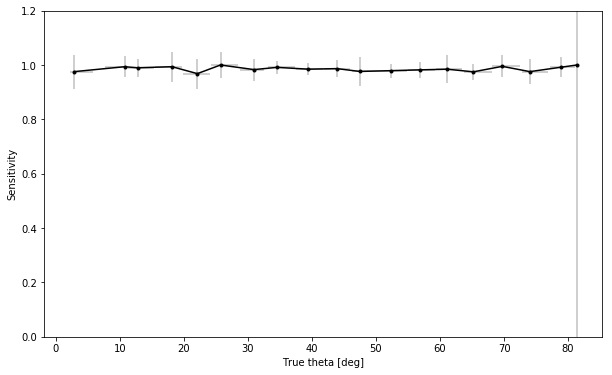

In [229]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_theta, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True theta [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

#### By azimuth angle (phi)

In [230]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_phi = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truephi')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


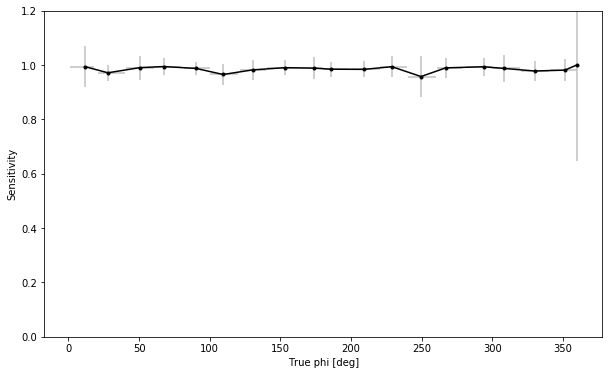

In [231]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_phi, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True phi [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

### Sensitivity on L1 (bgf=1) triggered *unclassified* events

In [232]:
extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_unclassified_nonan_df['event_id'].values, 
        simu_bgf1_unclassified_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


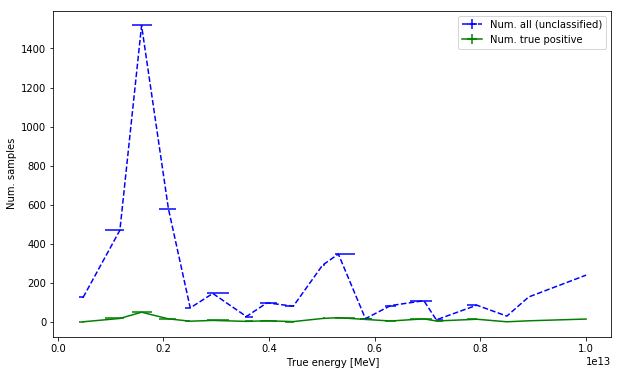

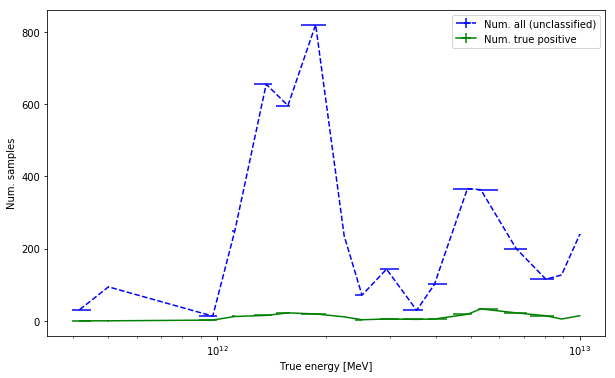

In [233]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. all (unclassified)', label='Num. all (unclassified)',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

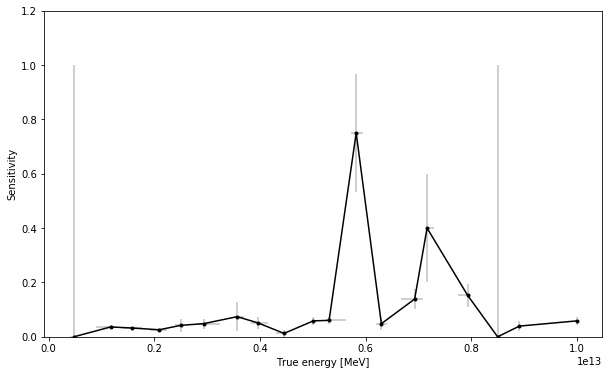

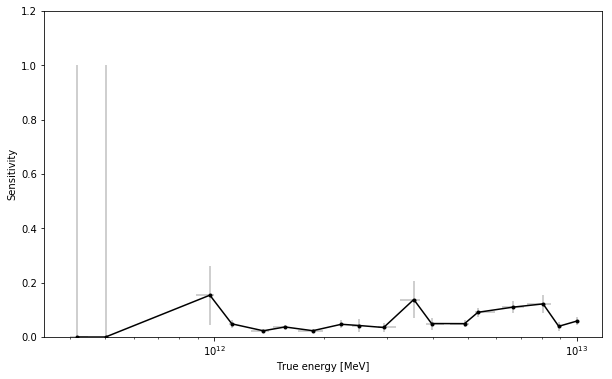

In [234]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

In [65]:
# backup for visualization

# extra_trees_classifier_y_pred_1_event_id = flight_nonan_event_id__values[extra_trees_classifier_on_train_kbest30__y_flight_pred == 1]
# events_to_vis_df = flight_df[flight_df['event_id'].isin(extra_trees_classifier_y_pred_1_event_id)].sort_values('rank', ascending=True)

# def print_classification(i, r, visualized_projections, fig, axs_flattened):
#     loc = np.argmax(flight_nonan_event_id__values == r['event_id'])
#     event_id_check = flight_nonan_event_id__values[loc]
#     extra_trees_classifier_y_pred = extra_trees_classifier_on_train_kbest30__y_flight_pred[loc]
    
#     print('\t----------------------------------')
#     print('\tevent_id_check =', event_id_check )
#     print('\textra_trees_classifier_y_pred =', extra_trees_classifier_y_pred )